In [30]:
# coding=utf-8
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy import signal as sg
from tqdm import tqdm
import time
# !pip install statsmodels
from statsmodels.tsa.stattools import adfuller
import random
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#930157', '#009966', '#72dfd9', '#e377c2',
          '#7f7f7f', '#bcbd22', '#17becf',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#930157', '#009966', '#72dfd9', '#e377c2',
          '#7f7f7f', '#bcbd22', '#17becf']
# !pip install mne
import mne
import os
from sklearn.decomposition import FastICA, PCA


def permutation_entropy(time_series, m, delay):
    """Calculate the Permutation Entropy

    Args:
        time_series: Time series for analysis
        m: Order of permutation entropy
        delay: Time delay

    Returns:
        Vector containing Permutation Entropy

    Reference:
        [1] Massimiliano Zanin et al. Permutation Entropy and Its Main Biomedical and Econophysics Applications:
            A Review. http://www.mdpi.com/1099-4300/14/8/1553/pdf
        [2] Christoph Bandt and Bernd Pompe. Permutation entropy — a natural complexity
            measure for time series. http://stubber.math-inf.uni-greifswald.de/pub/full/prep/2001/11.pdf
        [3] http://www.mathworks.com/matlabcentral/fileexchange/37289-permutation-entropy/content/pec.m
    """
    n = len(time_series)
    permutations = np.array(list(itertools.permutations(range(m))))
    c = [0] * len(permutations)

    for i in range(n - delay * (m - 1)):
        # sorted_time_series =    np.sort(time_series[i:i+delay*m:delay], kind='quicksort')
        sorted_index_array = np.array(np.argsort(time_series[i:i + delay * m:delay], kind='quicksort'))
        for j in range(len(permutations)):
            if abs(permutations[j] - sorted_index_array).any() == 0:
                c[j] += 1

    c = [element for element in c if element != 0]
    p = np.divide(np.array(c), float(sum(c)))
    pe = -sum(p * np.log(p)) / np.log(np.math.factorial(m))
    return pe


def signal_wise_entropy(fs, signal, window_duration, m, lag):
    number_of_periods = len(signal) // fs
    signal_entropy = []
    print("Number of periods:", number_of_periods)
    for starting_period in tqdm(range(number_of_periods)):
        signal_ = signal[starting_period * fs:(starting_period + window_duration) * fs]
        entropy = permutation_entropy(signal_, m, lag)
        signal_entropy.append(entropy)
    return signal_entropy


def plot_vector_in_time(vector, from_, to, from_time, to_time, title='Permutation entropy as a function of time',
                        xlabl='Time, s', ylabl='Entropy', labl=''):
    time_ = np.linspace(from_time, to_time, len(vector))

    fig = plt.figure(figsize=(30, 10))
    vector = vector[from_:to]
    plt.plot(time_, vector, COLORS[8], label=labl)
    plt.xlabel(xlabl, fontsize=18)
    plt.ylabel(ylabl, fontsize=18)
    plt.title(title, weight='bold', fontsize=35)
    plt.legend(fontsize='xx-large')
    return plt.show()


def plot_vector_in_counts(vector, from_, to, title='Permutation entropy as a function of time',
                          xlabl='Time, s', ylabl='Entropy', labl=''):
    start = from_ * 256
    end = to * 256
    time_ = np.linspace(from_, to, end-start)

    fig = plt.figure(figsize=(30, 10))
    vector = vector[start:end]
    plt.plot(time_, vector, COLORS[2], label=labl)
    plt.xlabel(xlabl, fontsize=18)
    plt.ylabel(ylabl, fontsize=18)
    plt.title(title, weight='bold', fontsize=35)
    plt.legend(fontsize='xx-large')
    return plt.show()


def plot_matrix_in_time(matrix, from_, to, title='Permutation entropy as a function of time',
                        xlabl='Time, s', ylabl='Entropy', labl='', separate=True):
    time_ = np.arange(from_, to, 1)

    fig = plt.figure(figsize=(30, 10))

    for i, e in enumerate(matrix):
        e = e[from_:to]
        plt.plot(time_, e, COLORS[i], label=labl)

        if separate:
            plt.xlabel(xlabl, fontsize=18)
            plt.ylabel(ylabl, fontsize=18)
            plt.title(title, weight='bold', fontsize=35)
            plt.legend(fontsize='xx-large')
            plt.show()

    plt.xlabel(xlabl, fontsize=18)
    plt.ylabel(ylabl, fontsize=18)
    plt.title(title, weight='bold', fontsize=35)
    plt.legend(fontsize='xx-large')
    return plt.show()


def plot_matrix_in_counts(matrix, from_, to, title='Permutation entropy as a function of time',
                          xlabl='Time, s', ylabl='Entropy', labl='', separate=True):
    start = from_ * 256
    end = to * 256
    time_ = np.linspace(from_, to, end-start)

    fig = plt.figure(figsize=(30, 10))

    for i, e in enumerate(matrix):

        e = e[start:end]


        if type(labl) == list:
            plt.plot(time_, e, COLORS[i], label=labl[i])
        else:
            plt.plot(time_, e, COLORS[i])

        if separate:
            plt.xlabel(xlabl, fontsize=18)
            plt.ylabel(ylabl, fontsize=18)
            plt.title(title, weight='bold', fontsize=35)
            plt.legend(fontsize='xx-large')
            plt.show()

    plt.xlabel(xlabl, fontsize=18)
    plt.ylabel(ylabl, fontsize=18)
    plt.title(title, weight='bold', fontsize=35)
    plt.legend(fontsize='xx-large')
    return plt.show()


class EEG_sample:
    def __init__(self, file, seizure_times):
        self.file = file
        self.raw = mne.io.read_raw_edf(file)
        self.raw_data = self.raw.get_data()
        self.original_signal = self.raw.get_data()
        # you can get the metadata included in the file and a list of all channels:
        self.info = self.raw.info
        self.channels = self.raw.ch_names
        self.fs = 256
        self.pe_ica = False
        self.seizure_time = seizure_times
        self.seizure_times = seizure_times
        self.window_before = random.randint(50, 200)
        self.window_after = random.randint(50, 200)
        print("Windows before-after:", self.window_before, self.window_after)
        self.signal_around_seizure = [self.raw_data[i][seizure_times[0] - self.window_before:seizure_times[1] + self.window_after]
                                      for i in range(self.raw_data.shape[0])]

        self.filtered_signal = self._filter()

        self.average_all_channels = self.get_average(self.filtered_signal)


    def determine_PE(self):
        self.averaged_entropy = {}
        self.average_pe = self.get_averaged_permutation_entropy(1, 4, 1)

    def determine_ica(self):
        self.ica = self.get_ica()
        self.average_ica = self.get_average(self.ica)

    def determine_fourier(self):
        self.fourier_transform = self.get_fourier_transform()

    def determine_features(self):
        self.features = self.get_features()

    def _filter(self, l_freq=0.5, h_freq=40):
        return self.raw.copy().load_data().filter(l_freq=l_freq, h_freq=h_freq).get_data()

    def determine_pe_ica(self):
        self.pe_ica = self.get_permutation_entropy_all_channels(self.ica, 1, 4, 1)

    def define_spectum(self):
        self.spectrum = self.get_fourier_transform()

    def get_average(self, channels):

        averaged_ = []

        for a in range(len(channels[0])):
            value = []
            for vector in channels:
                value.append(vector[a])
            averaged_.append(sum(value) / len(value))

        return averaged_

    def get_ica(self):
        raw_data = self.filtered_signal.T
        np.random.seed(0)

        ica = FastICA(n_components=24)
        print("Fitting ICA")
        start = time.time()
        S_ = ica.fit_transform(raw_data)
        print("fitting took:", time.time() - start)

        print('ICA shape', S_.shape)
        print('Plotting')
        plot_matrix_in_counts(S_.T, from_=0, to=S_.shape[0] // 256, title='Independent component plot',
                              xlabl='Time, s', ylabl='Signal', labl=['component ' + str(i) for i in range(S_.shape[1])],
                              separate=True)
        return S_.T
        # SELECTING only stationary time series
#         result1 = []
#         for i, component in enumerate(S_.T):
#             print("Component processing:", i)
#             result = adfuller(component)
#             print("For component "+str(i)+" result is "+str(result))
#             print("P-value:", str(result[1]))
#             if result[1] > 0.05:
#                 result1.append(component)

#         result1 = np.ndarray(result1)
#         return result1

    def get_features(self):
        features_matrix = []
        features_matrix.append(self.average_pe)
        filtered_average = []
        for el in range(0, self.raw_data.shape[1], 256):
            filtered_average.append(self.average_all_channels[el])

        features_matrix.append(filtered_average)
        for component in self.ica:
            features_matrix.append(component)

        if self.pe_ica:
            for pe in self.pe_ica:
                features_matrix.append(pe)

        return features_matrix

    def get_mask(self):
        mask = []
        for i in range(self.raw_data.shape[1]//256):
            if i not in range(self.seizure_times[0], self.seizure_times[1]):
                mask.append(0)
            else:
                mask.append(1)
        self.mask = np.array(mask)

    def get_fourier_transform(self):
        spectrograms = []
        for ch in self.filtered_signal:
            sp = sg.spectrogram(ch, fs=256, window='blackman',
                                    nperseg=int(0.5 * 256))
            f, t, Sxx = sp
            spectrograms.append(Sxx)

        return spectrograms



    @staticmethod
    def permutation_entropy(time_series, m, delay):
        '''Calculate the Permutation Entropy

        Args:
            time_series: Time series for analysis
            m: Order of permutation entropy
            delay: Time delay

        Returns:
            Vector containing Permutation Entropy

        Reference:
            [1] Massimiliano Zanin et al. Permutation Entropy and Its Main Biomedical and Econophysics Applications:
                A Review. http://www.mdpi.com/1099-4300/14/8/1553/pdf
            [2] Christoph Bandt and Bernd Pompe. Permutation entropy — a natural complexity
                measure for time series. http://stubber.math-inf.uni-greifswald.de/pub/full/prep/2001/11.pdf
            [3] http://www.mathworks.com/matlabcentral/fileexchange/37289-permutation-entropy/content/pec.m
        '''
        n = len(time_series)
        permutations = np.array(list(itertools.permutations(range(m))))
        c = [0] * len(permutations)

        for i in tqdm(range(n - delay * (m - 1))):
            # sorted_time_series =    np.sort(time_series[i:i+delay*m:delay], kind='quicksort')
            sorted_index_array = np.array(np.argsort(time_series[i:i + delay * m:delay], kind='quicksort'))
            for j in range(len(permutations)):
                if abs(permutations[j] - sorted_index_array).any() == 0:
                    c[j] += 1

        c = [element for element in c if element != 0]
        p = np.divide(np.array(c), float(sum(c)))
        pe = -sum(p * np.log(p)) / np.log(np.math.factorial(m))
        return pe

    def get_permutation_entropy_all_channels(self, channels, window_duration, m, lag, visualize=True):

        permutation_en = []
        # ADDED for calculation shortage
        count_start = (self.seizure_time[0] - self.window_before) * self.fs
        count_end = (self.seizure_time[1] + self.window_after) * self.fs
        for s in range(len(channels)):
            print('Channel:', s, self.channels[s])
            # ADDED for calculation shortage
            signal = channels[s][count_start:count_end]

            fs = self.fs

            signal_entropy = signal_wise_entropy(fs, signal, window_duration, m, lag)

            if visualize == True:
                time_ = np.linspace(self.seizure_time[0] - self.window_before, self.seizure_time[1] + self.window_after,
                                    len(signal_entropy))

                fig = plt.figure(figsize=(30, 10))

                plt.plot(time_, signal_entropy, COLORS[s], label="Channel " + str(s))
                plt.xlabel('Time, s', fontsize=18)
                plt.ylabel('Entropy', fontsize=18)
                plt.title('Permutation entropy as a function of time ' + str(self.seizure_time), weight='bold',
                          fontsize=35)
                plt.legend(fontsize='xx-large')
                plt.show()

            permutation_en.append(signal_entropy)

        return permutation_en

    def get_averaged_permutation_entropy(self, window_duration, m, lag, channels = None):
        if channels == None:
            channels = self.raw_data

        name = 'window=' + str(window_duration) + ', m=' + str(m) + ', lag=' + str(lag)
        if name not in self.averaged_entropy.keys():

            print("Getting averaged for " + self.file)

            averaged_permutation_en = []
            permutation_en = self.get_permutation_entropy_all_channels(channels, window_duration, m, lag)

            for a in range(len(permutation_en[0])):
                value = []
                for vector in permutation_en:
                    value.append(vector[a])
                averaged_permutation_en.append(sum(value) / len(value))

            self.averaged_entropy[name] = averaged_permutation_en
            self.average_pe = averaged_permutation_en

        else:
            averaged_permutation_en = self.averaged_entropy[name]

        return averaged_permutation_en


In [31]:
import numpy as np
from sklearn.linear_model import LinearRegression
from hyperopt import fmin, hp, tpe

class Predictor:
    def __init__(self):
        self.fitted = False

    def fit(self, list_of_samples):
        raise NotImplementedError

    def predict(self, list_):
        raise NotImplementedError

    def predict(self, sample):
        raise NotImplementedError

class PermutationEntropyPredictor(Predictor):
    def __init__(self):
        super(PermutationEntropyPredictor, self).__init__()
        self.best = None


    def fit(self, list_of_samples, optimize = False):

        def predict_time_based_on_pe(pe, window, step, k_boundary):
#             print("Params:",window, step, k_boundary)
            if step == 0:
                return -1000
            if k_boundary < 0 or k_boundary > 1:
                return -1000
            
            if len(range(0, len(pe) - window, step)) == 0:
                return -1000
            
            slopes = []
            for i in range(0, len(pe) - window, step):
                x = np.array([j for j in range(window)]).reshape(-1, 1)
                y = np.array([pe[j] for j in range(i, i + window)])
                
                lr = LinearRegression().fit(x, y)
                m = lr.coef_[0]
                slopes.append(m)
            
            counts_time = []
            for i, slope in enumerate(slopes):
                if np.abs(slope) > k_boundary:
                    counts_time.append(i)
            if len(counts_time) == 0:
                m_ = slopes.index(max(slopes))
            else:
                m_ = max(counts_time)
            return m_*step

        def _predict_time(search_space):

            window = search_space['window']
            step = search_space['step']
            k_boundary = search_space['k_boundary']

            errors = []
            for sample in list_of_samples:
                start_time = sample.seizure_times[0]
                pe = sample.average_pe
                predicted_time = predict_time_based_on_pe(pe, window, step, k_boundary)
                predicted_time = predicted_time - sample.window_before + sample.seizure_times[0]
                error = np.abs(start_time - predicted_time)
                errors.append(error)

            return sum(errors)/len(errors)

        search_space = {
                'window': hp.choice('window', np.arange(1, 100, dtype=int)),
                'step': hp.choice('step', np.arange(1, 100, dtype=int)),
        'k_boundary': hp.lognormal('k_boundary', 0, 1)}

        if optimize:
            algo = tpe.suggest
            self.best = fmin(fn=_predict_time,
                space=search_space,
                algo=algo,
                max_evals=950)
        else:

            windows = []
            errors = []
            for sample in list_of_samples:
                window = sample.seizure_times[1] - sample.seizure_times[0]
                windows.append(window)
                window = sum(windows)/len(windows)
                pe = sample.average_pe
                step = 1

                k_boundary = 0.0
                predicted_time = predict_time_based_on_pe(pe, window, step, k_boundary)
                predicted_time = predicted_time - sample.window_before + sample.seizure_times[0]
                error = np.abs(sample.seizure_times[0] - predicted_time)

                errors.append(error)

            self.best = {'window' : sum(windows)/len(windows), 'step':1, 'k_boundary':0.0}




    def predict(self, list_):
        def predict_time_based_on_pe(pe, window, step, k_boundary):
            if step == 0:
                return -1000
            if k_boundary < 0 or k_boundary > 1:
                return -1000
            
            if len(range(0, len(pe) - window, step)) == 0:
                return -1000
            
            slopes = []
            for i in range(0, len(pe) - window, step):
                x = np.array([j for j in range(window)]).reshape(-1, 1)
                y = np.array([pe[j] for j in range(i, i + window)])
                
                lr = LinearRegression().fit(x, y)
                m = lr.coef_[0]
                slopes.append(m)
            
            counts_time = []
            for i, slope in enumerate(slopes):
                if np.abs(slope) > k_boundary:
                    counts_time.append(i)
                    
            if len(counts_time) == 0:
                m_ = slopes.index(max(slopes))
            else:
                m_ = max(counts_time)
                
            return m_*step
        
        predictions = []
        for sample in list_:
            start_time = sample.seizure_times[0]
            pe = sample.average_pe
            predicted_time = predict_time_based_on_pe(pe, self.best['window'], self.best['step'], self.best['k_boundary'])
            predicted_time = predicted_time - sample.window_before + sample.seizure_times[0]
            predictions.append(predicted_time)
            error = np.abs(start_time - predicted_time)
        return predictions


    def predict(self, sample, vector):
        def predict_time_based_on_pe(pe, window, step, k_boundary):
            if step == 0:
                return -1000
            
            if len(range(0, len(pe) - window, step)) == 0:
                return -1000
            
            slopes = []
            for i in range(0, len(pe) - window, step):
                x = np.array([j for j in range(window)]).reshape(-1, 1)
                y = np.array([pe[j] for j in range(i, i + window)])
                
                lr = LinearRegression().fit(x, y)
                m = lr.coef_[0]
                slopes.append(m)
            
            counts_time = []
            for i, slope in enumerate(slopes):
                if np.abs(slope) > k_boundary:
                    counts_time.append(i)
                    
            if len(counts_time) == 0:
                m_ = slopes.index(max(slopes))
            else:
                m_ = max(counts_time)
                
            return m_*step
        start_time = sample.seizure_times[0]
        pe = sample.average_pe
        predicted_time = predict_time_based_on_pe(pe, self.best['window'], self.best['step'], self.best['k_boundary'])
        predicted_time = predicted_time - sample.window_before + sample.seizure_times[0]
        error = np.abs(start_time - predicted_time)
        return predicted_time








In [32]:
DIR_ = "/Users/sofiyagarkot/Desktop/Signals/coursework/test_data/"
os.chdir(DIR_)

raws_correspond = {'chb09':{'chb09_06':[[12231,12295]]}}
# raws_correspond = {'chb15':{'chb15_40':[[834,894], [2378,2497], [3362, 3425]], 'chb15_15': [[1591,1748]], 
# #                             'ch
#                             20':[[607,662]], 'chb15_17':[[1925,1960]], 'chb15_28':[[876,1066]], 
#                            }
#                             'chb15_62':[[751, 859]], 'chb15_46':[[3322,3429]], 
#                         'chb15_54':[[263,318], [843, 1020], [1524, 1595], [2179, 2250], [3428, 3460]], 
#                             'chb15_31':[[1751,1871]], 'chb15_52':[[778, 849]], 
#                             'chb15_10':[[1082,1113]], 'chb15_06':[[272, 397]]},
#                   'chb09':{'chb09_08':[[2951, 3030], [9196, 9267]], 'chb09_19':[[5299, 5361]], 'chb09_06':[[12231,12295]]},
#                   'chb23':{'chb23_09':[[2589, 2660], [6885, 6947], [8505, 8532], [9580, 9664]], 
#                            'chb23_06':[[3962, 4075]], 'chb23_08':[[325, 345], [5104, 5151]]},
#                   'chb06':{'chb06_13':[[506,519]], 'chb06_04':[[327, 347], [6211, 6231]], 'chb06_24':[[9387, 9403]], 
#                            'chb06_01':[[1724,1738],[7461, 7476], [13525, 13540]], 'chb06_18':[[7799, 7811]],
#                           'chb06_10':[[10833, 10845]], 'chb06_09':[[12500, 12516]]},
#                   'chb01':{'chb01_03':[[2996, 3036]], 'chb01_04':[[1467,1494]], 'chb01_15':[[1732, 1772]],
#                       'chb01_16':[[1015, 1066]], 'chb01_18':[[1720,1810]], 'chb01_21':[[327, 420]], 'chb01_26':[[1862, 1963]]},
#                   'chb20':{'chb20_12':[[94, 123]], 'chb20_13':[[1440, 1470], [2498, 2537]], 'chb20_14':[[1971, 2009]],
#                           'chb20_15':[[390, 425], [1689,1738]], 'chb20_16':[[2226, 2261]], 'chb20_68':[[1393, 1432]]}
#                   }


samples = []

for d in os.listdir():
    if d in raws_correspond.keys():
        print(d)
        os.chdir(DIR_+"/"+d)
        for file in os.listdir():
            print(file)
            if file[:-4] in raws_correspond[d].keys():
                for part_of_signal in raws_correspond[d][file[:-4]]:
                    print("part_of_signal",part_of_signal)
                    eeg_sample = EEG_sample(file, part_of_signal)
                    samples.append(eeg_sample)
    
            elif file[6:-4] in raws_correspond[d].keys():
                for part_of_signal in raws_correspond[d][file[6:-4]]:
                    print("part_of_signal",part_of_signal)
                    eeg_sample = EEG_sample(file, part_of_signal)
                    samples.append(eeg_sample)

chb09
chb09_19.edf
chb09_08.edf
entropy_.txt
chb09_08.edf.seizures
chb09_19.edf.seizures
.ipynb_checkpoints
chb09_06.edf
part_of_signal [12231, 12295]
Extracting EDF parameters from /Users/sofiyagarkot/Desktop/Signals/coursework/test_data/chb09/chb09_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-30-4677706a8ecf>:156: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(file)


Windows before-after: 146 181
Reading 0 ... 3686143  =      0.000 ... 14398.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 sec)

chb09_06.edf.seizures
chb09_02.edf


In [33]:
len(samples)

1

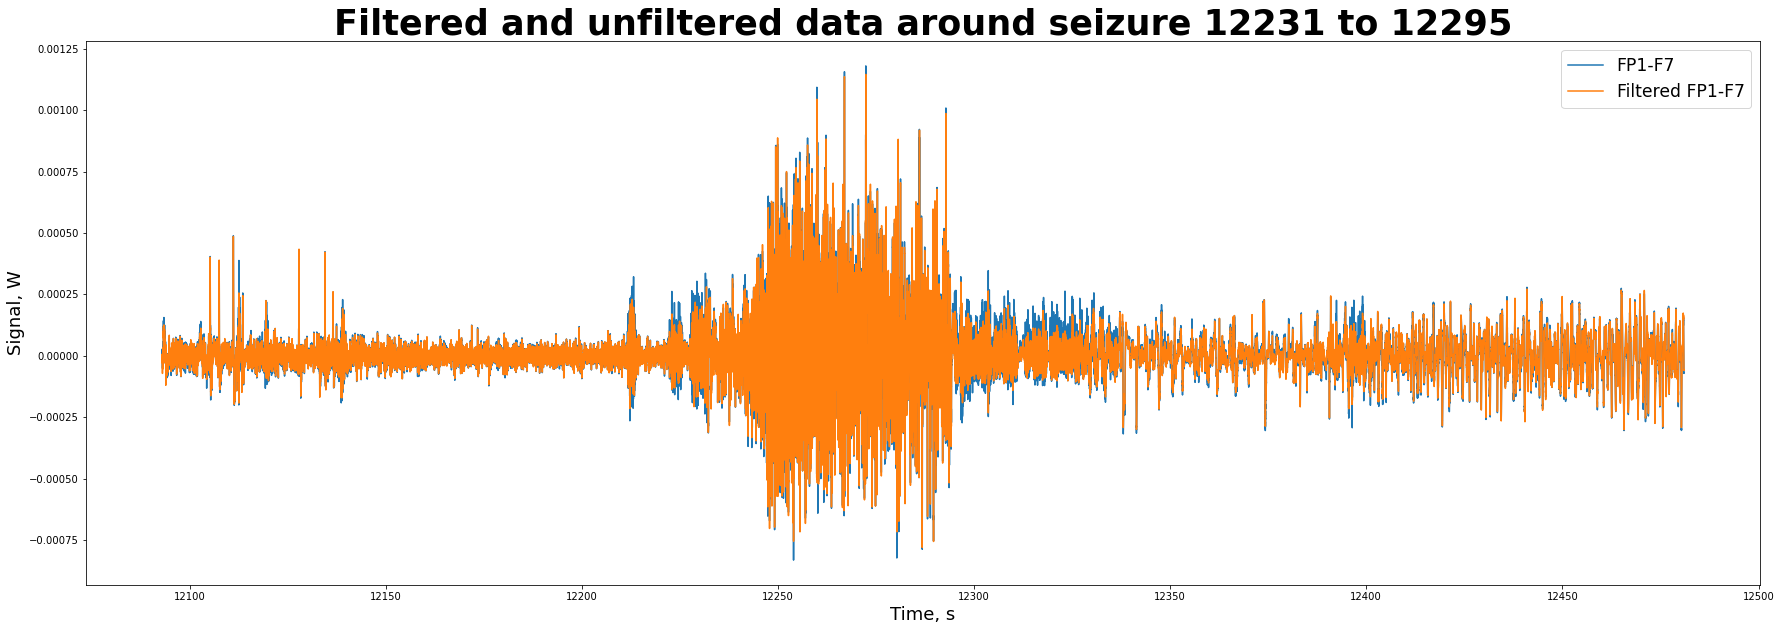

In [25]:
for sample in samples:
    plot_matrix_in_counts([sample.original_signal[0],
                           sample.filtered_signal[0]],
                          sample.seizure_times[0] - sample.window_before, sample.seizure_times[1] + sample.window_after,
                         title="Filtered and unfiltered data around seizure "+str(sample.seizure_times[0])+" to "+str(sample.seizure_times[1]), 
                         ylabl='Signal, W', labl=[sample.channels[0], "Filtered "+sample.channels[0]], separate = False)
    
    
    
    
    
    

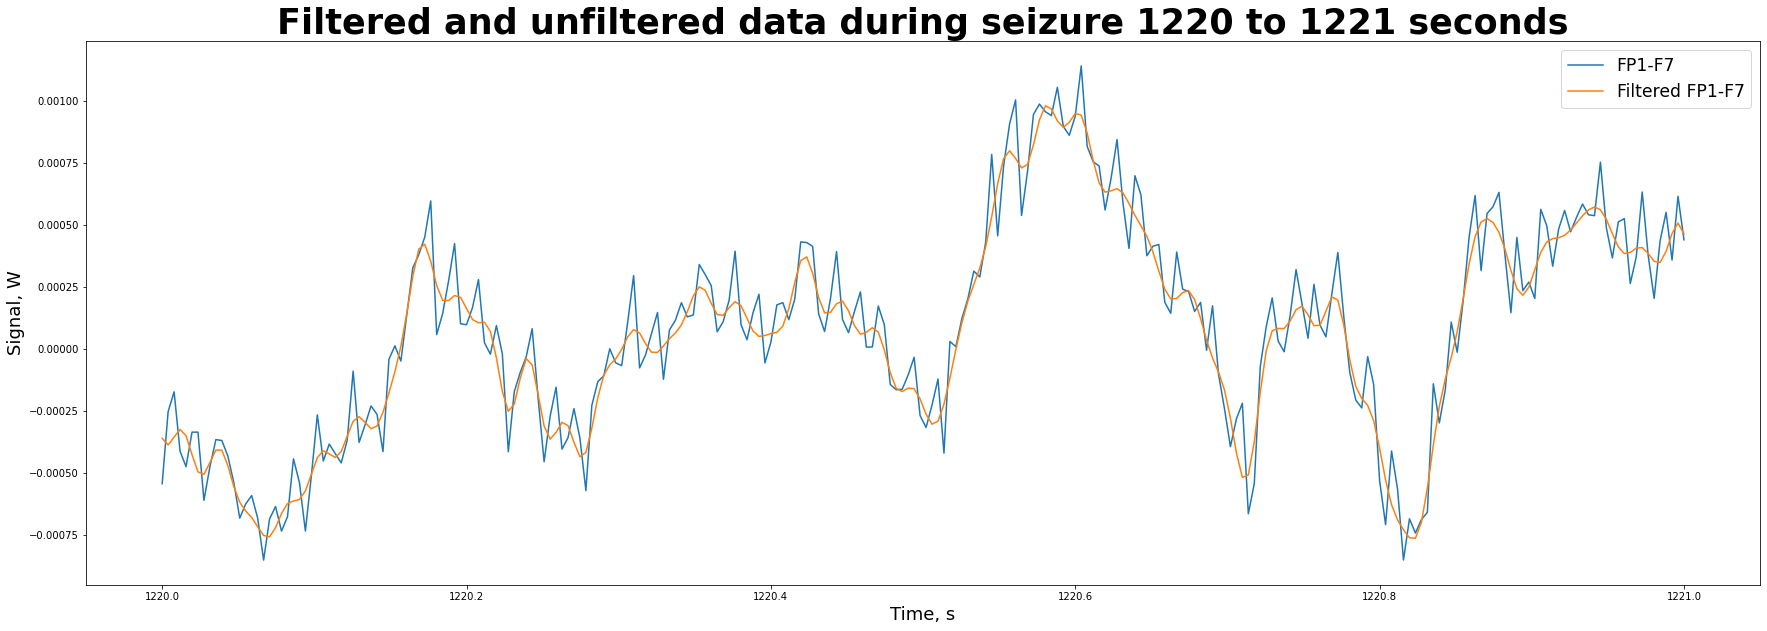

In [26]:
for sample in samples:
    plot_matrix_in_counts([sample.original_signal[0],
                           sample.filtered_signal[0]],
                          1220, 1221,
                         title="Filtered and unfiltered data during seizure 1220 to 1221 seconds", 
                         ylabl='Signal, W', labl=[sample.channels[0], "Filtered "+sample.channels[0]], separate = False)
    
    

  1%|          | 4/388 [00:00<00:11, 33.67it/s]

Getting averaged for chb09_06.edf
Channel: 0 FP1-F7
Number of periods: 388


100%|██████████| 388/388 [00:11<00:00, 34.05it/s]


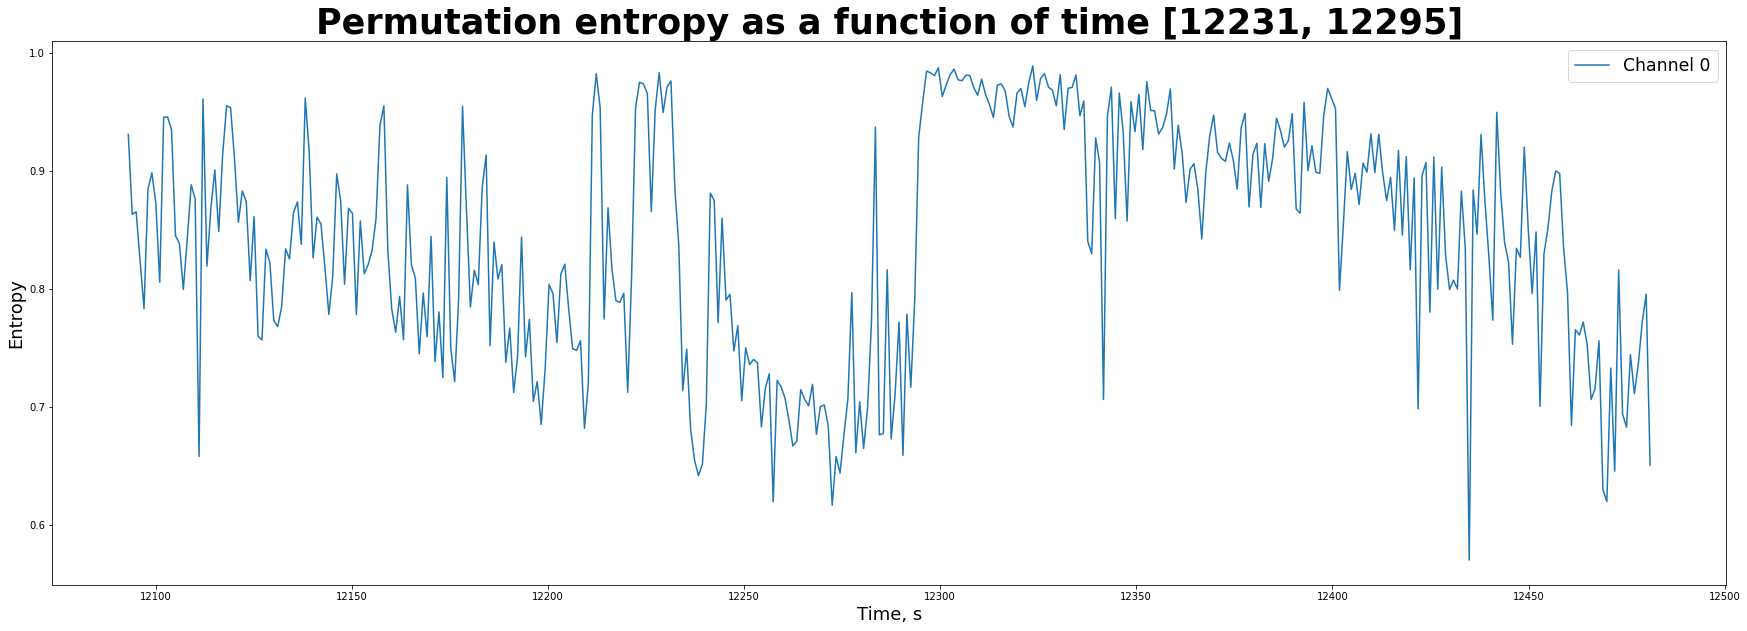

  1%|          | 4/388 [00:00<00:11, 34.20it/s]

Channel: 1 F7-T7
Number of periods: 388


100%|██████████| 388/388 [00:12<00:00, 31.19it/s]


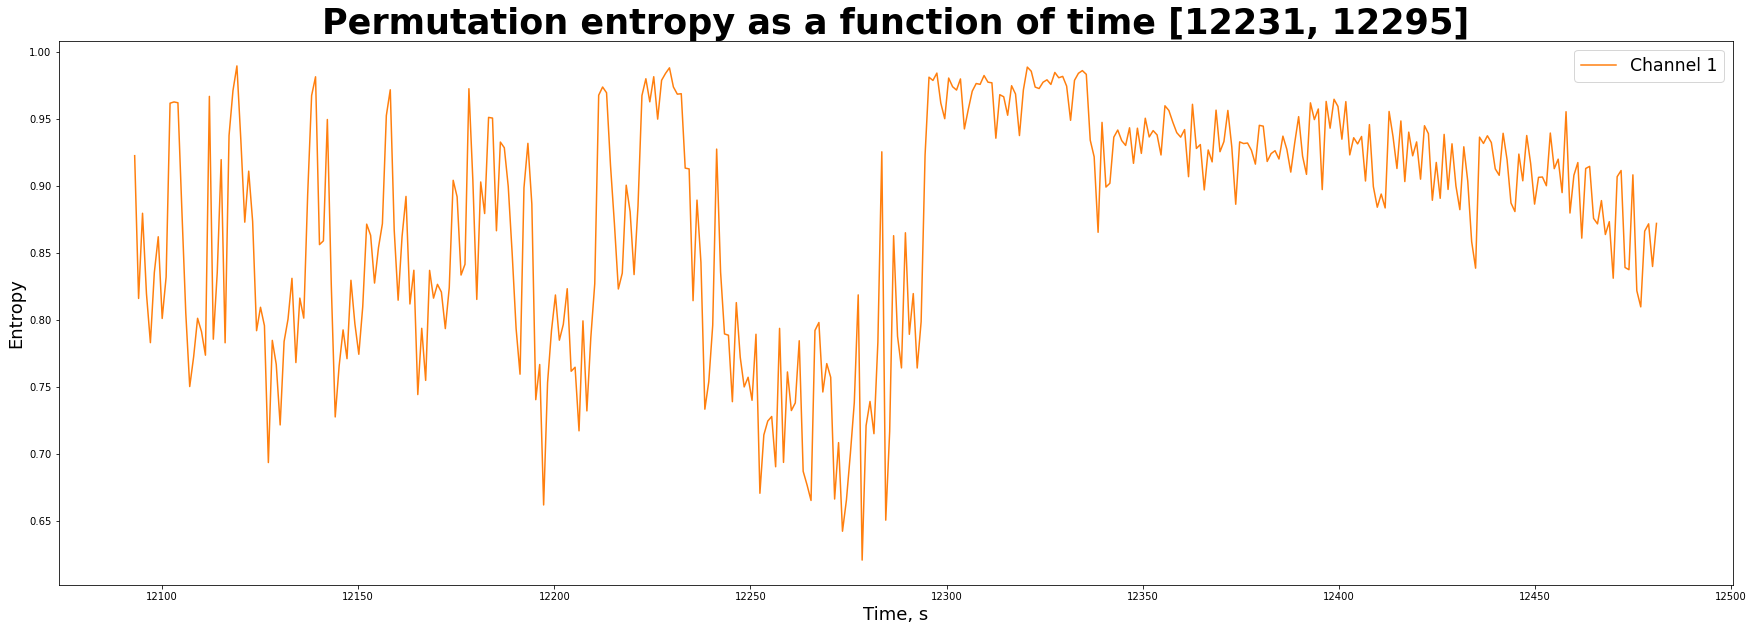

  2%|▏         | 7/388 [00:00<00:13, 28.59it/s]

Channel: 2 T7-P7
Number of periods: 388


100%|██████████| 388/388 [00:12<00:00, 30.53it/s]


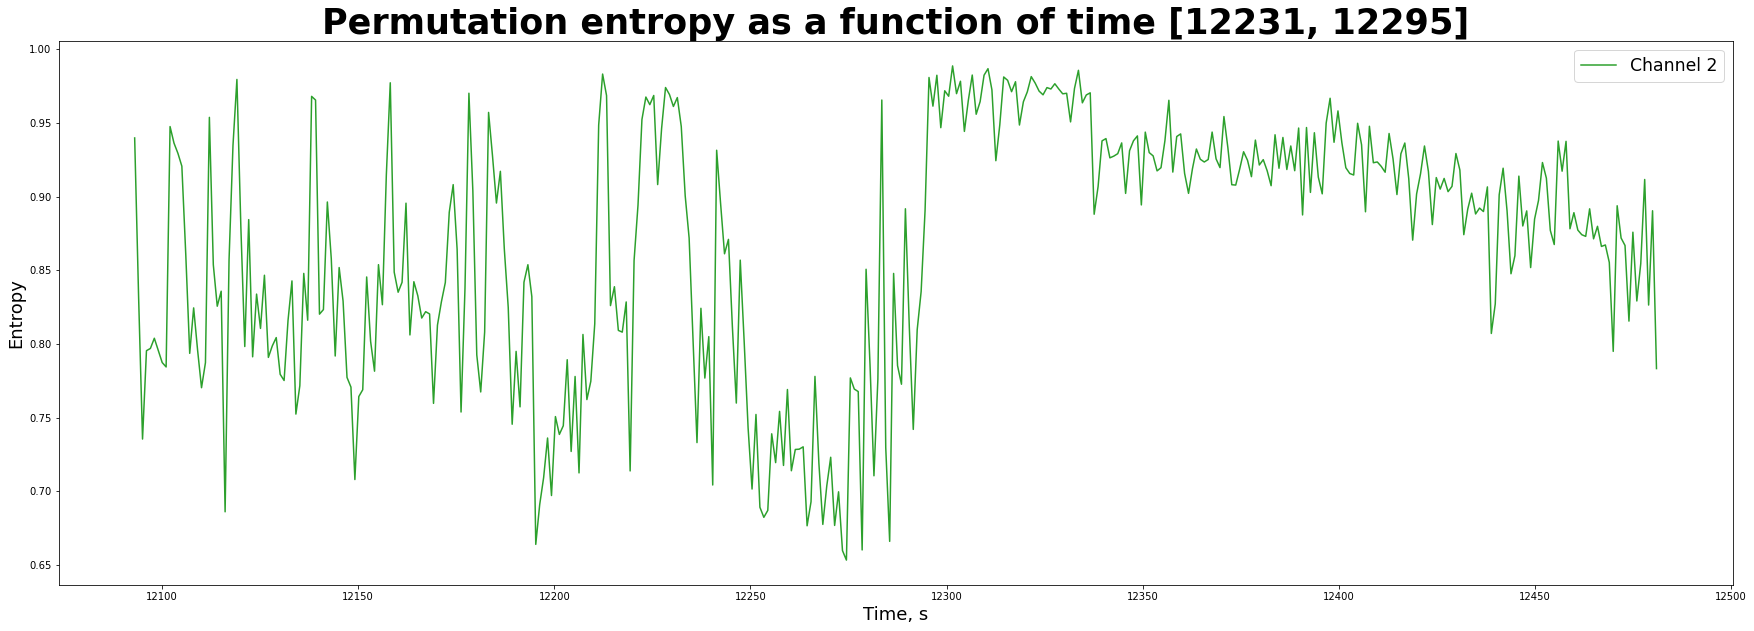

  1%|          | 4/388 [00:00<00:10, 35.79it/s]

Channel: 3 P7-O1
Number of periods: 388


100%|██████████| 388/388 [00:13<00:00, 28.77it/s]


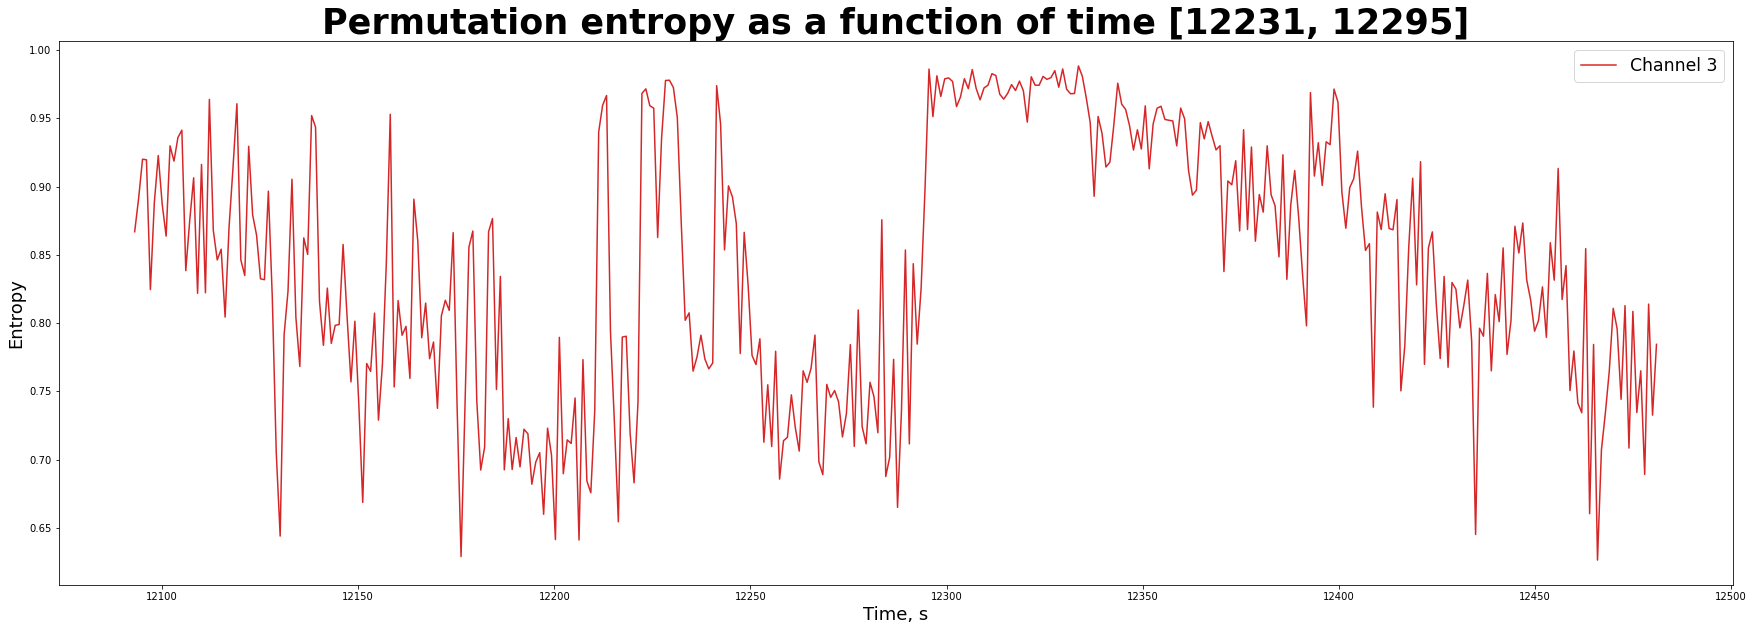

  1%|          | 4/388 [00:00<00:11, 33.80it/s]

Channel: 4 FP1-F3
Number of periods: 388


100%|██████████| 388/388 [00:11<00:00, 33.49it/s]


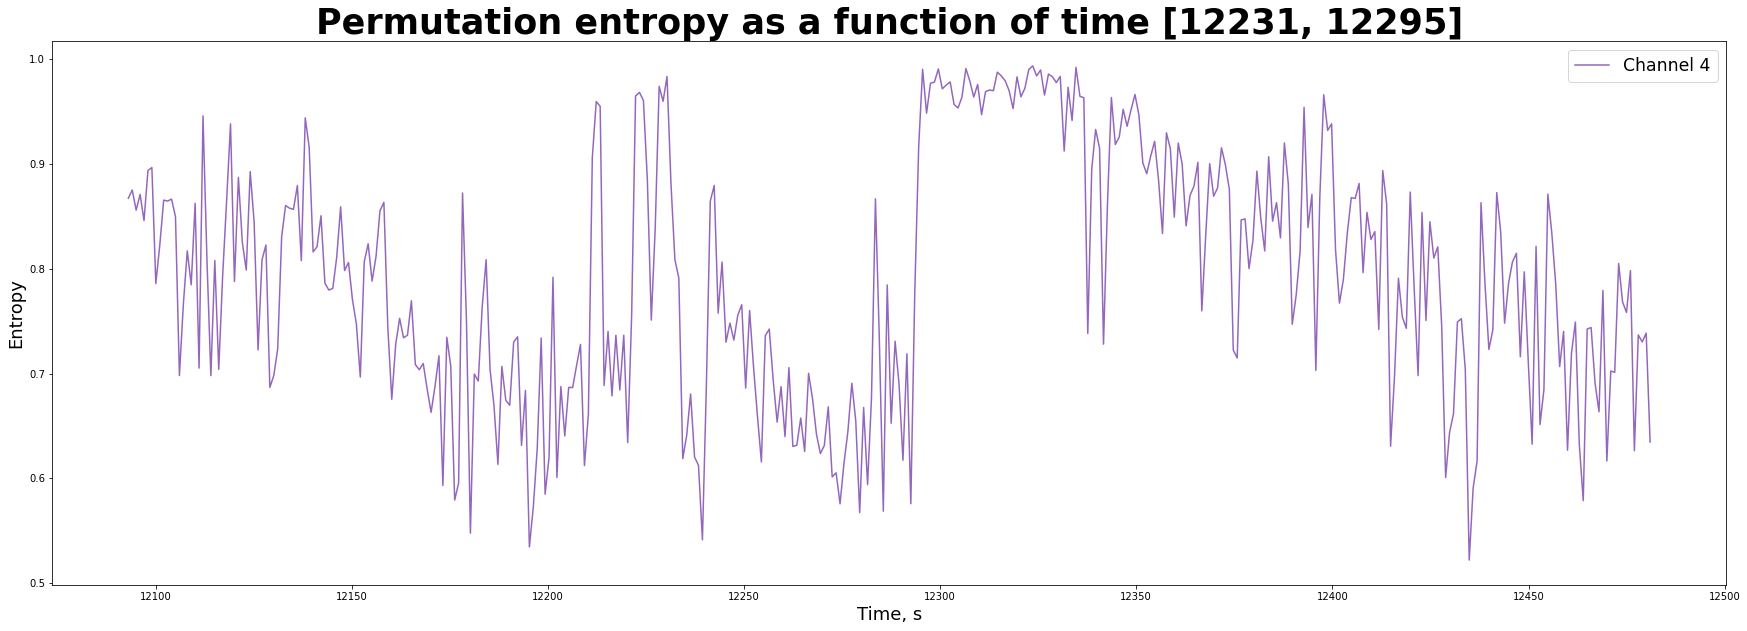

  1%|          | 3/388 [00:00<00:14, 27.20it/s]

Channel: 5 F3-C3
Number of periods: 388


100%|██████████| 388/388 [00:13<00:00, 28.41it/s]


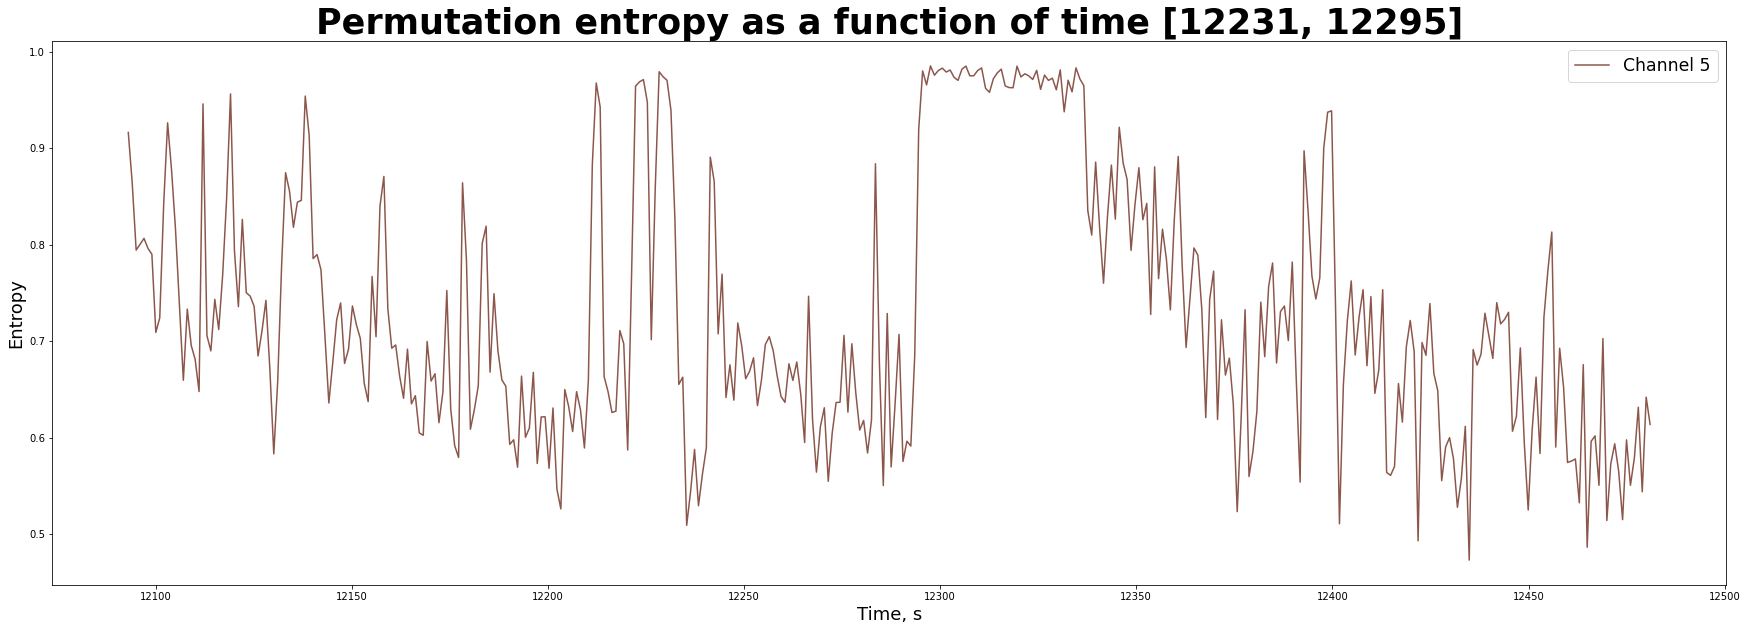

  1%|          | 3/388 [00:00<00:16, 23.43it/s]

Channel: 6 C3-P3
Number of periods: 388


100%|██████████| 388/388 [00:11<00:00, 33.80it/s]


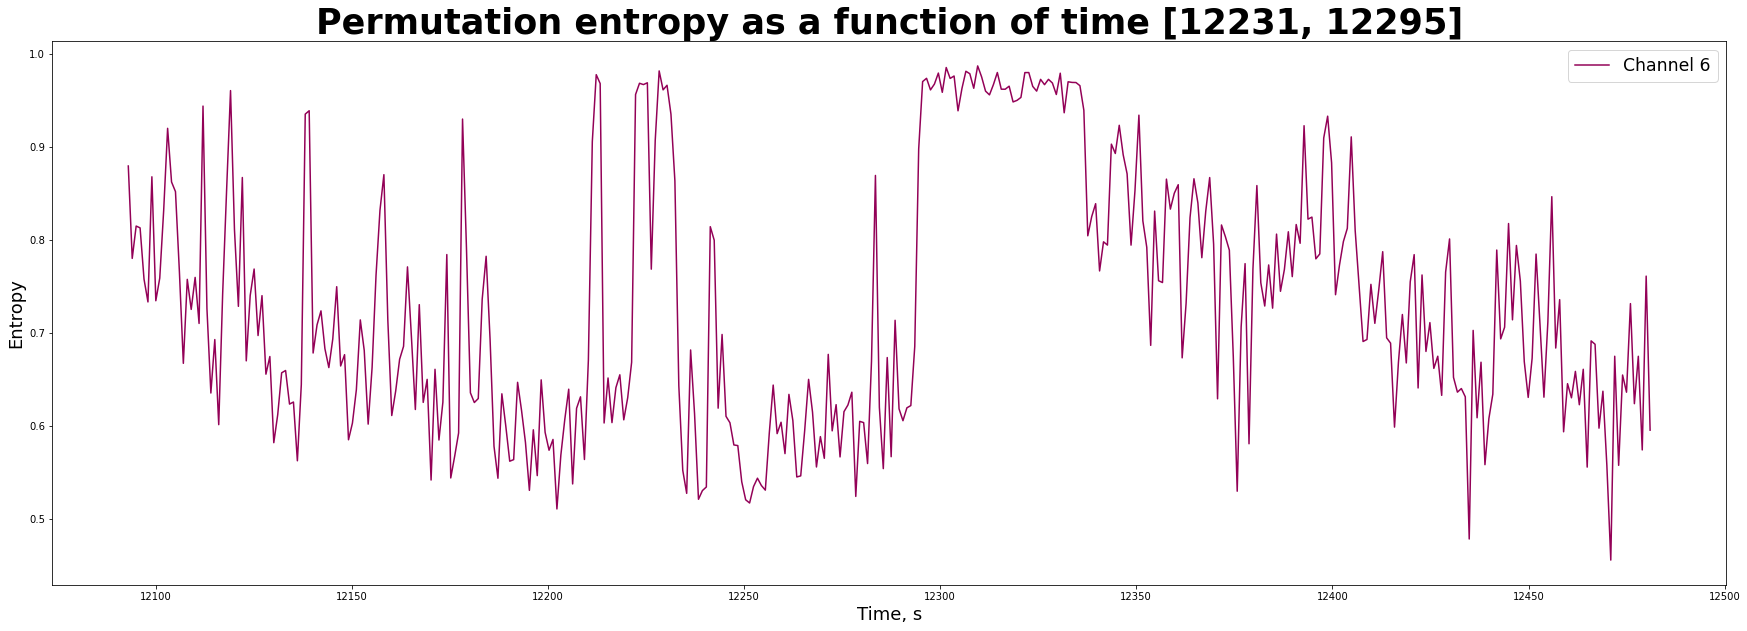

  1%|          | 4/388 [00:00<00:10, 36.57it/s]

Channel: 7 P3-O1
Number of periods: 388


100%|██████████| 388/388 [00:11<00:00, 32.48it/s]


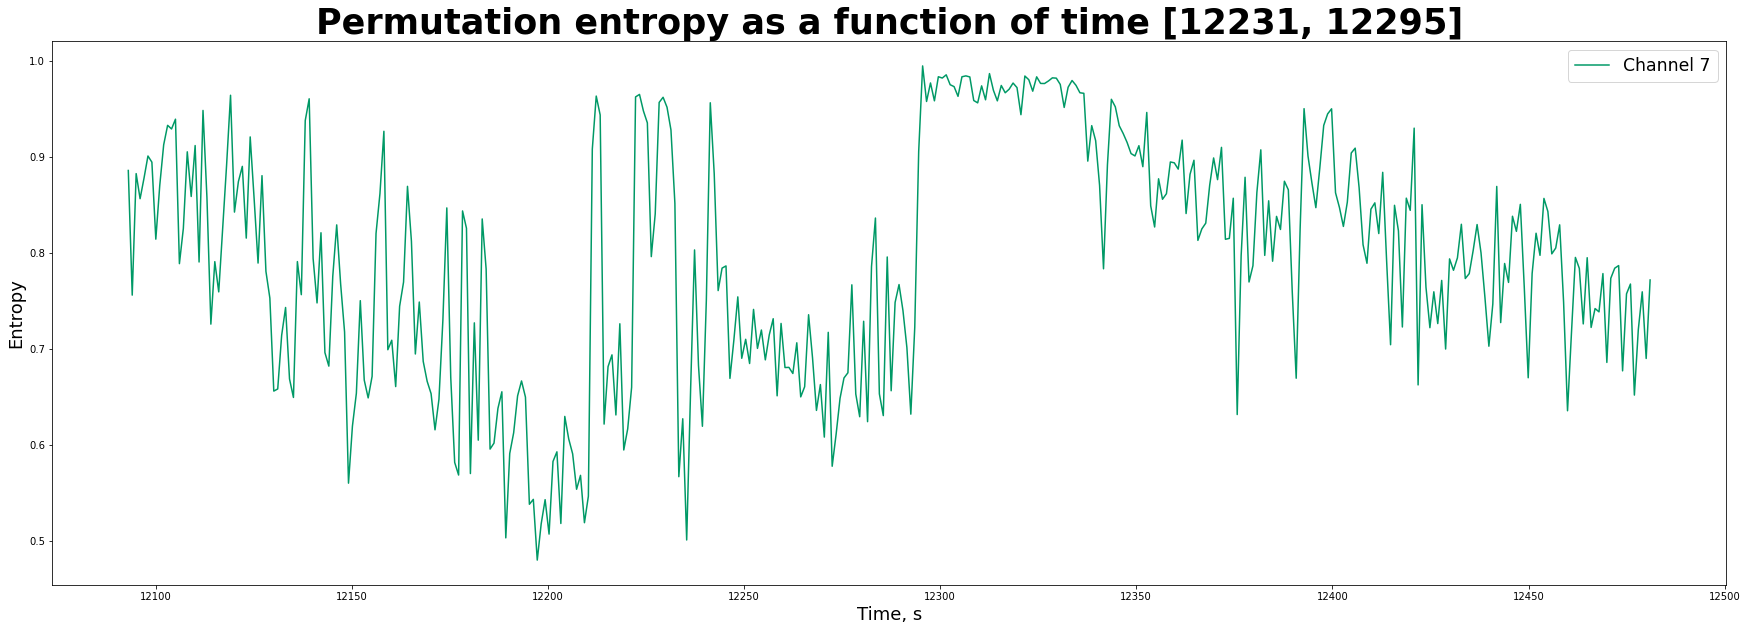

  1%|          | 4/388 [00:00<00:09, 39.61it/s]

Channel: 8 FP2-F4
Number of periods: 388


100%|██████████| 388/388 [00:13<00:00, 29.55it/s]


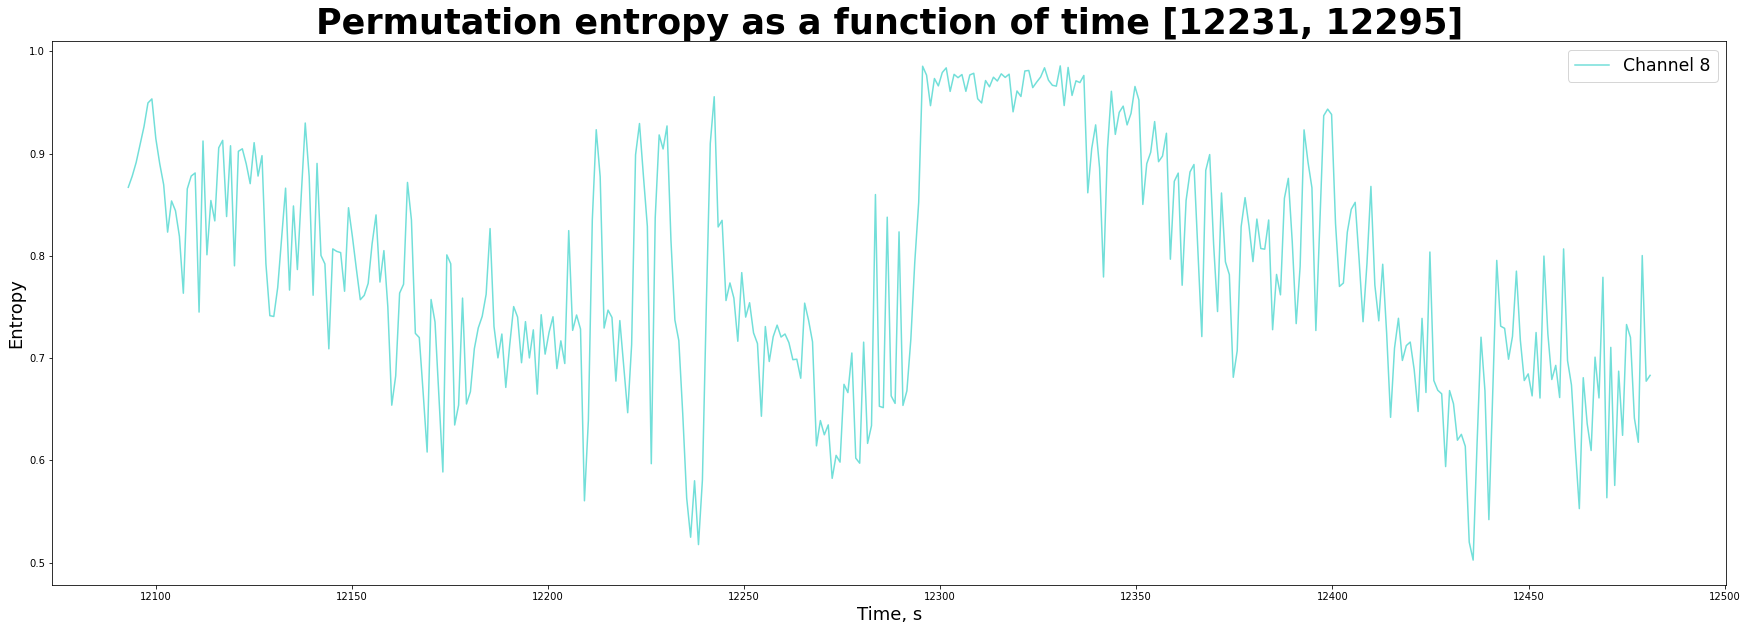

  2%|▏         | 6/388 [00:00<00:15, 24.07it/s]

Channel: 9 F4-C4
Number of periods: 388


100%|██████████| 388/388 [00:12<00:00, 30.12it/s]


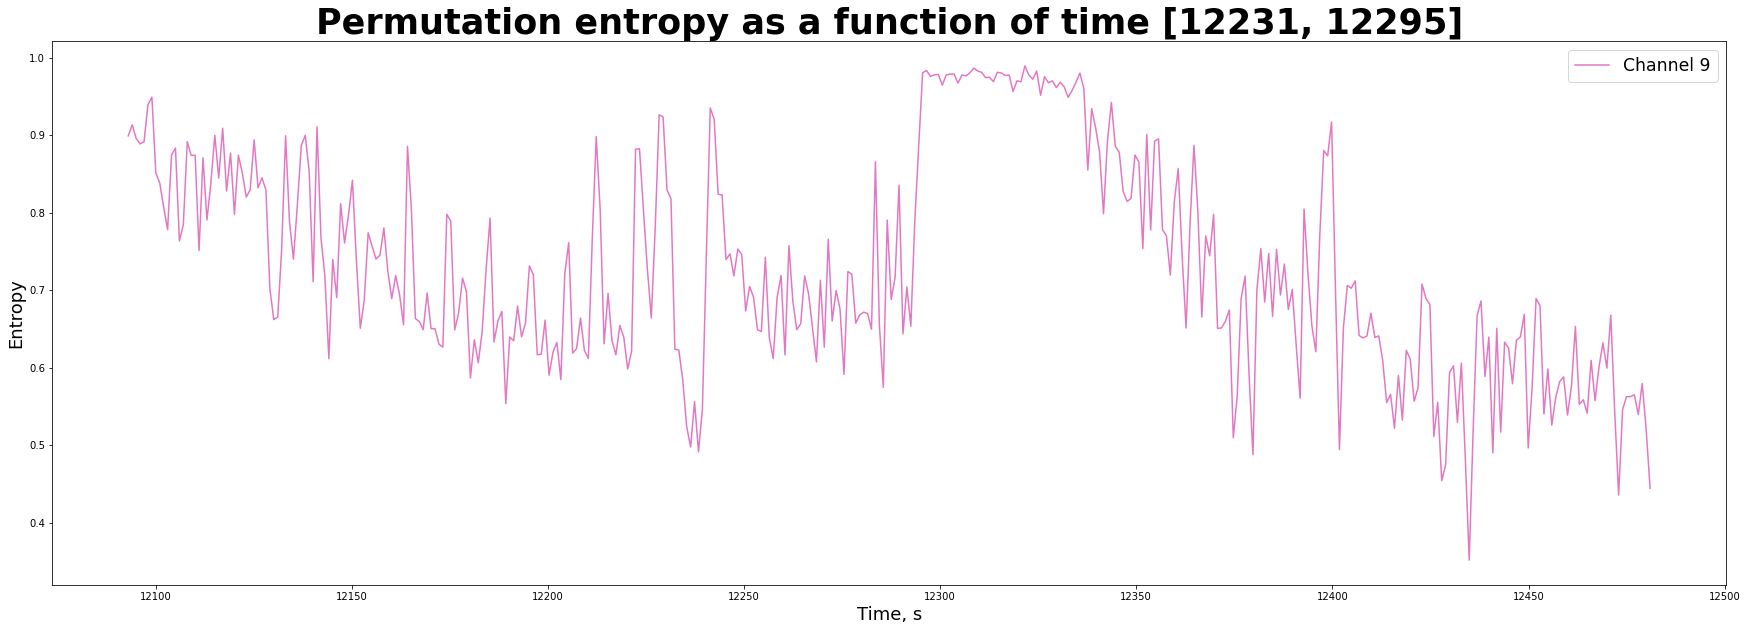

  1%|          | 4/388 [00:00<00:11, 33.82it/s]

Channel: 10 C4-P4
Number of periods: 388


100%|██████████| 388/388 [00:11<00:00, 35.09it/s]


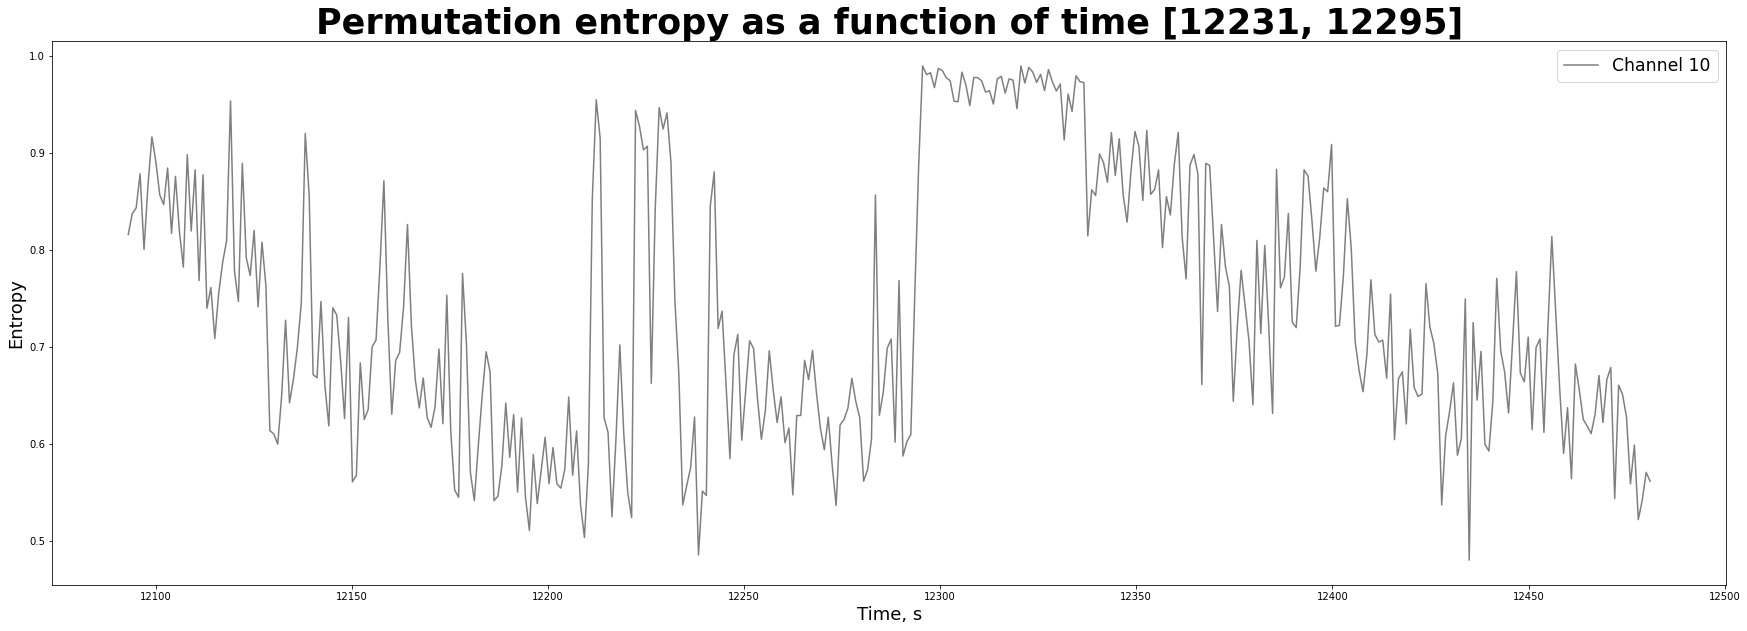

  2%|▏         | 9/388 [00:00<00:09, 38.33it/s]

Channel: 11 P4-O2
Number of periods: 388


100%|██████████| 388/388 [00:10<00:00, 35.82it/s]


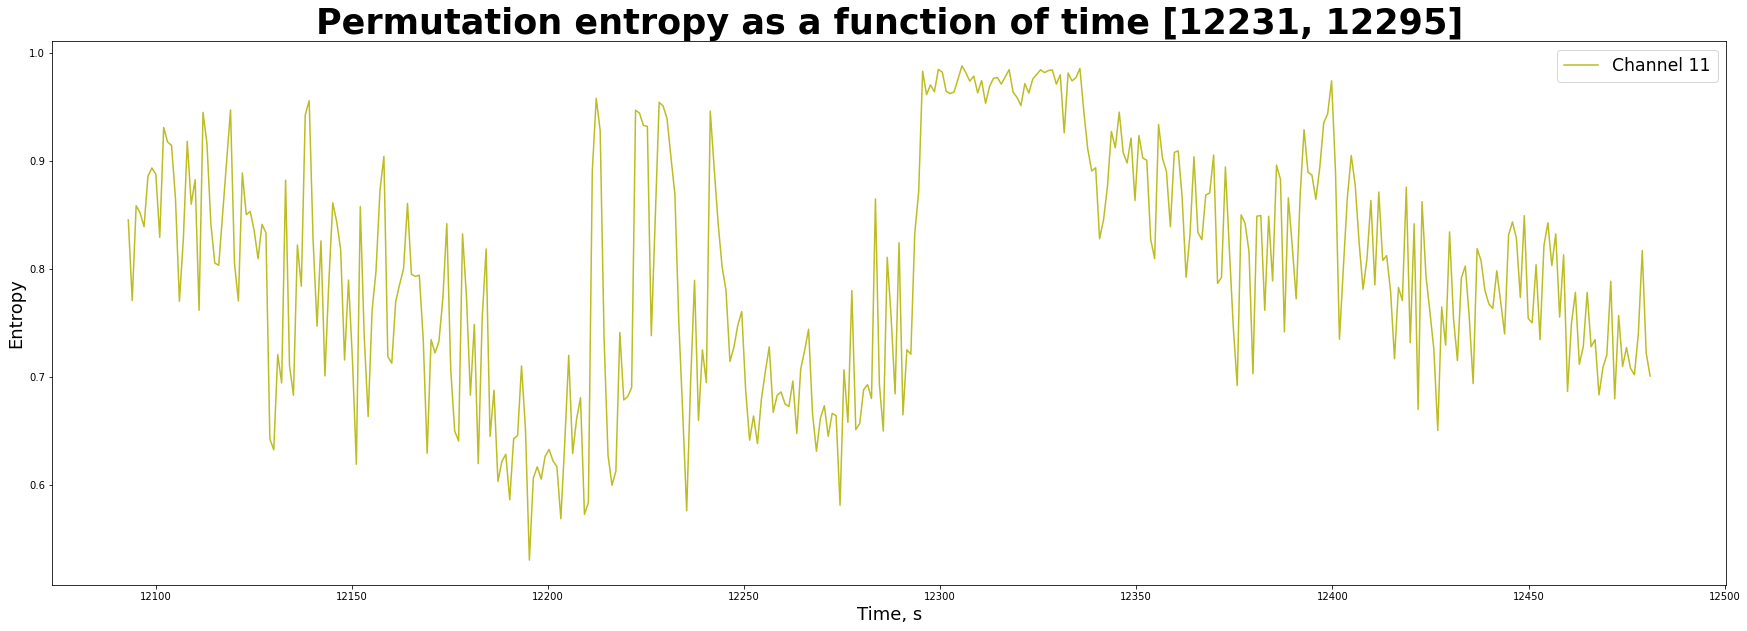

  2%|▏         | 8/388 [00:00<00:09, 38.30it/s]

Channel: 12 FP2-F8
Number of periods: 388


100%|██████████| 388/388 [00:10<00:00, 36.22it/s]


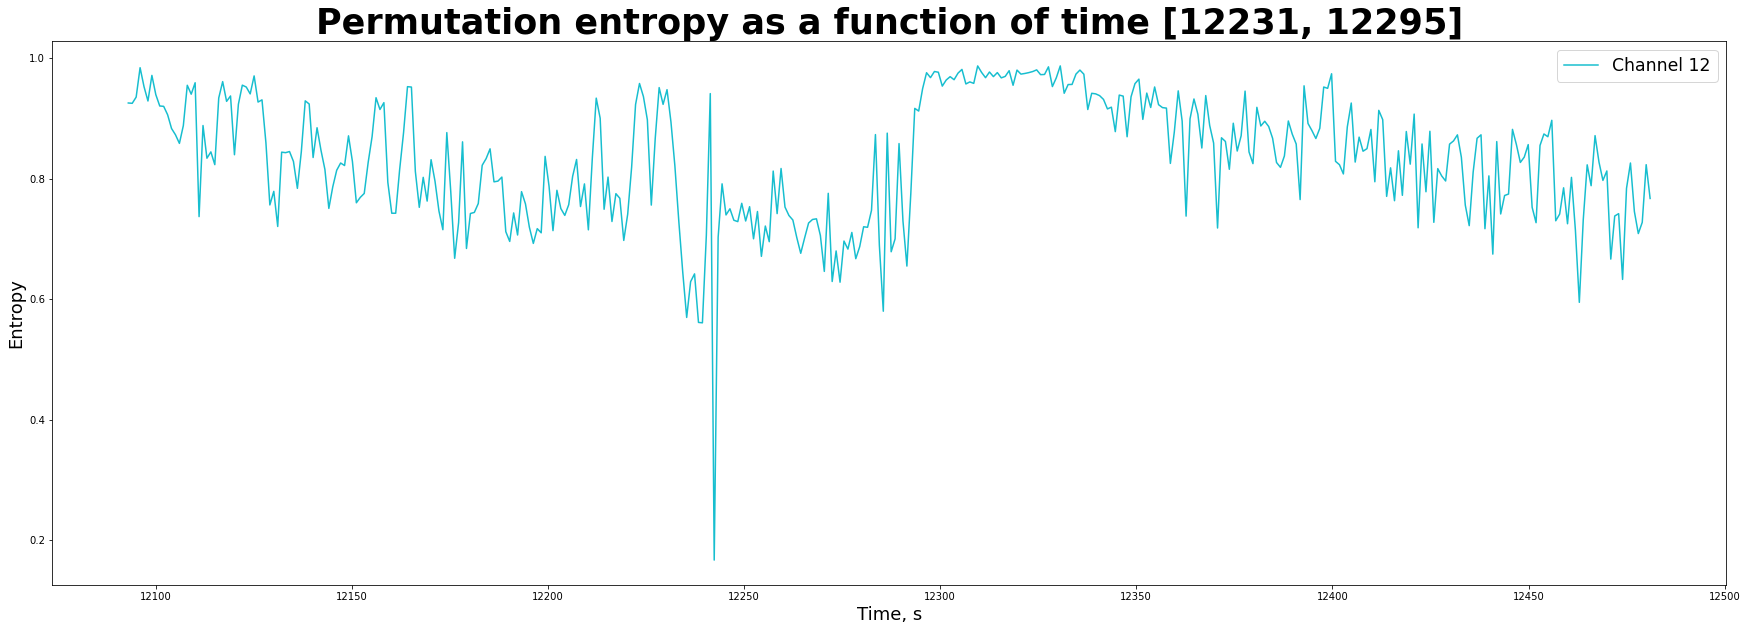

  1%|          | 4/388 [00:00<00:12, 31.65it/s]

Channel: 13 F8-T8
Number of periods: 388


100%|██████████| 388/388 [00:10<00:00, 36.68it/s]


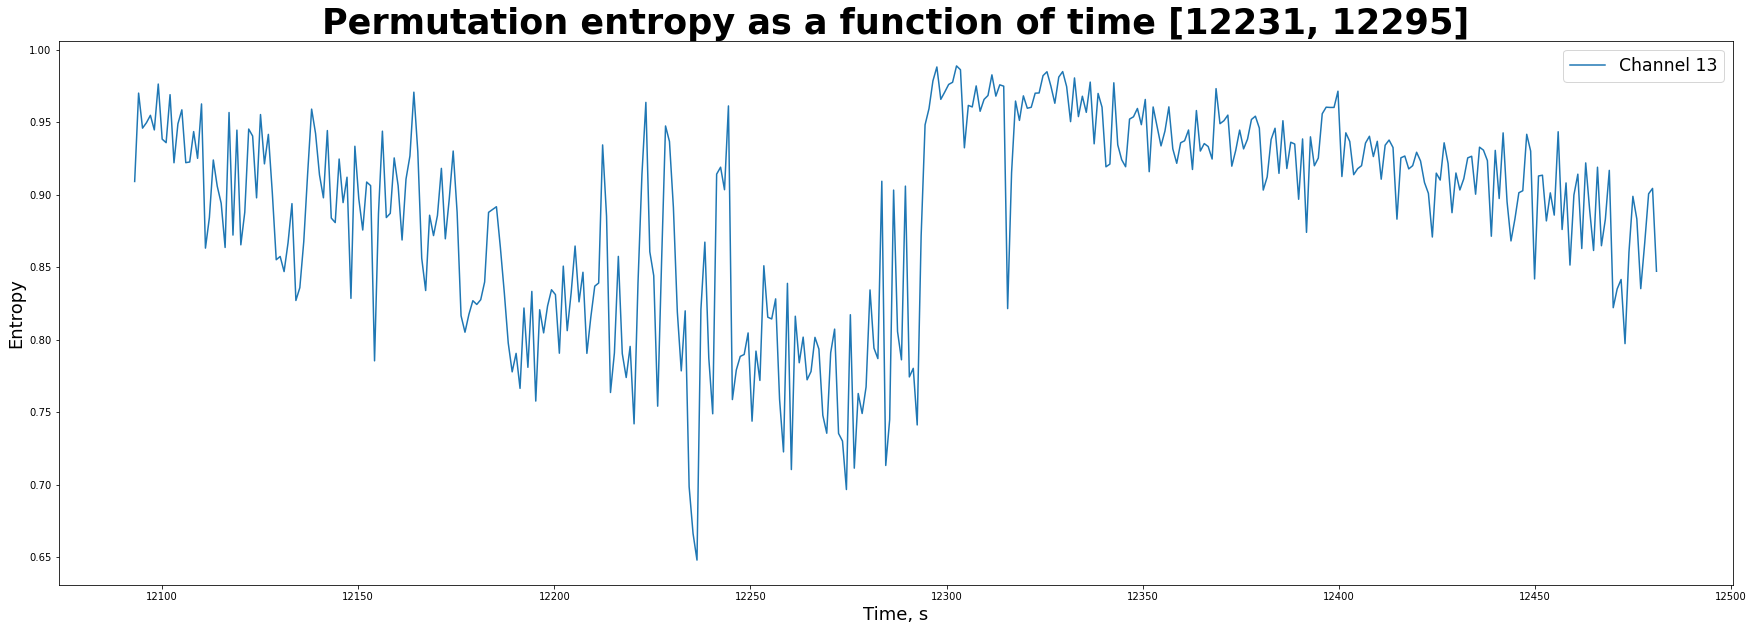

  1%|          | 3/388 [00:00<00:13, 28.85it/s]

Channel: 14 T8-P8-0
Number of periods: 388


100%|██████████| 388/388 [00:11<00:00, 34.10it/s]


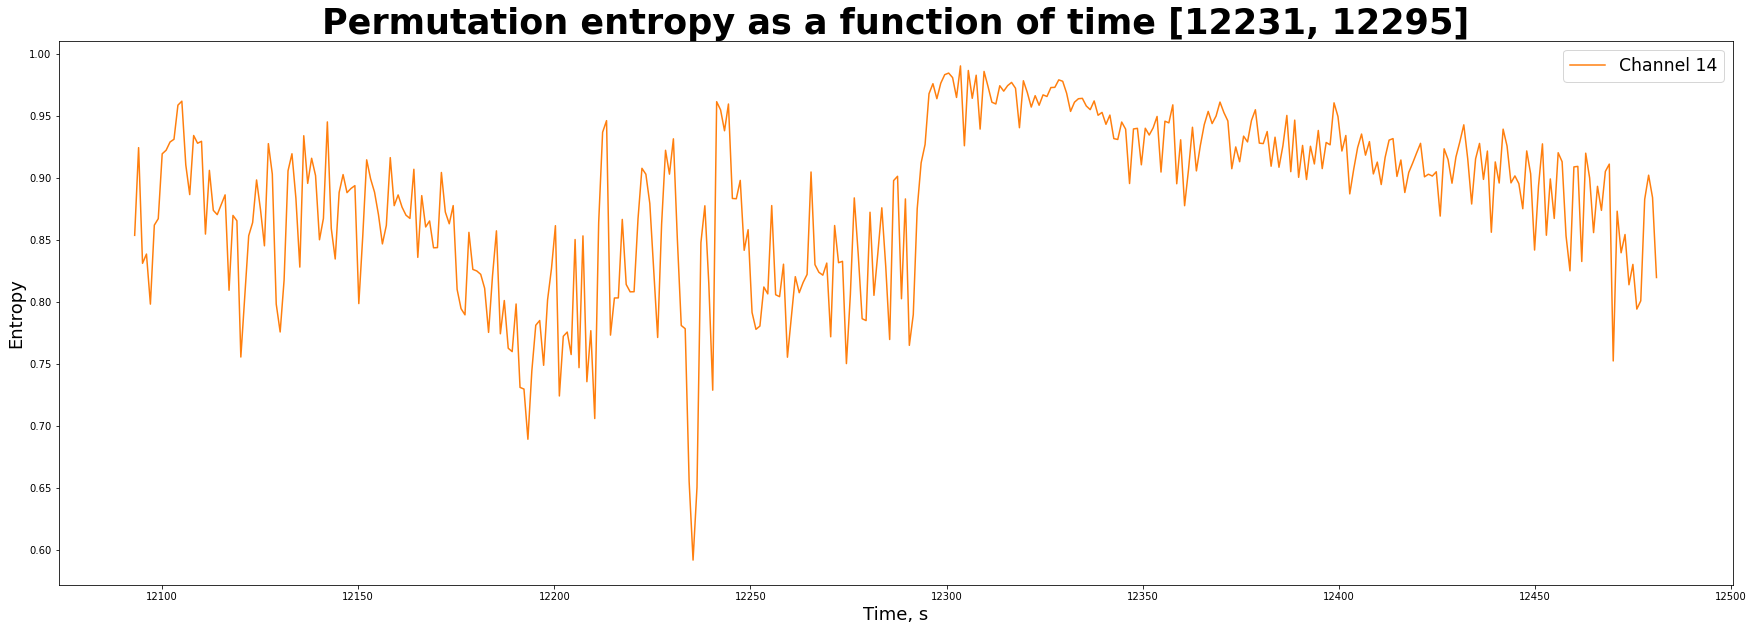

  2%|▏         | 8/388 [00:00<00:10, 35.79it/s]

Channel: 15 P8-O2
Number of periods: 388


100%|██████████| 388/388 [00:10<00:00, 37.39it/s]


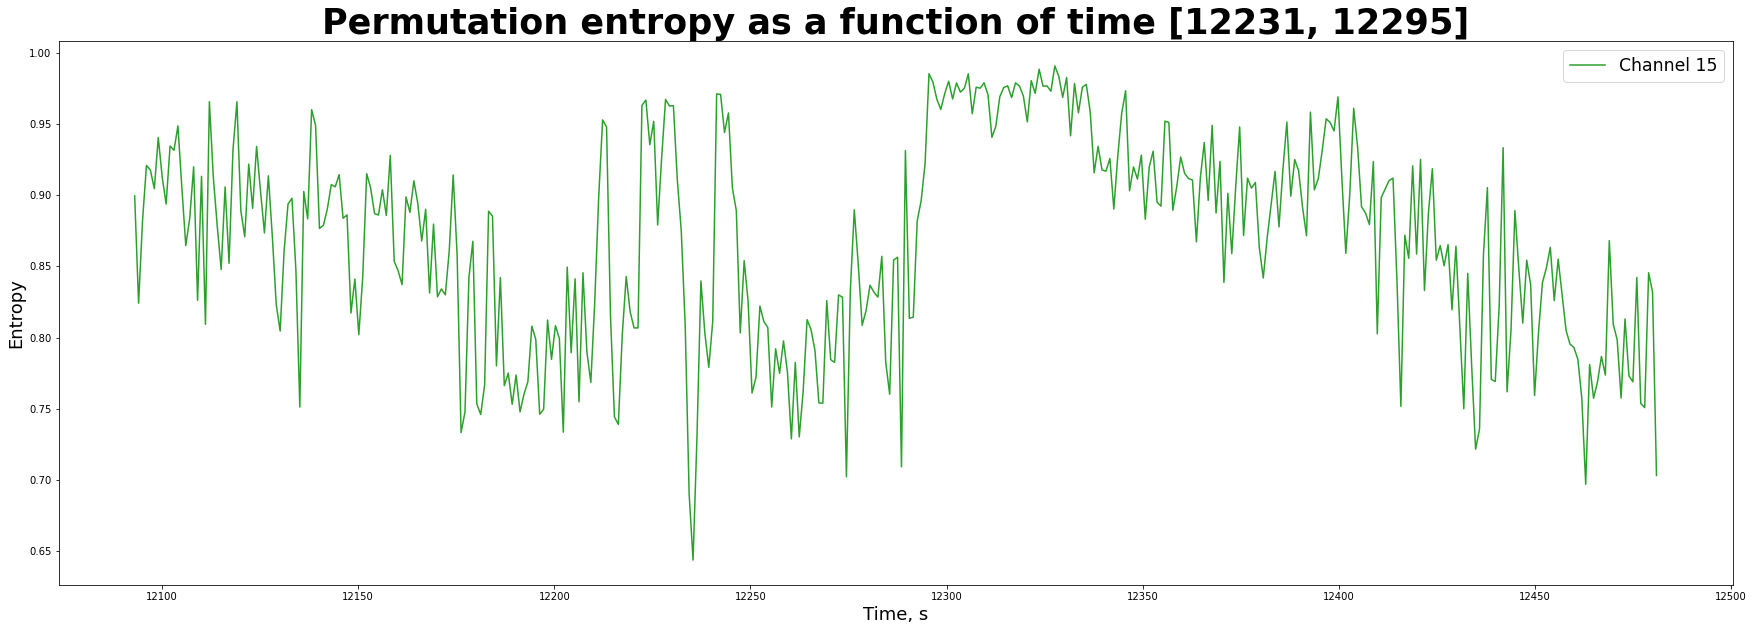

  1%|          | 4/388 [00:00<00:10, 36.33it/s]

Channel: 16 FZ-CZ
Number of periods: 388


100%|██████████| 388/388 [00:10<00:00, 35.83it/s]


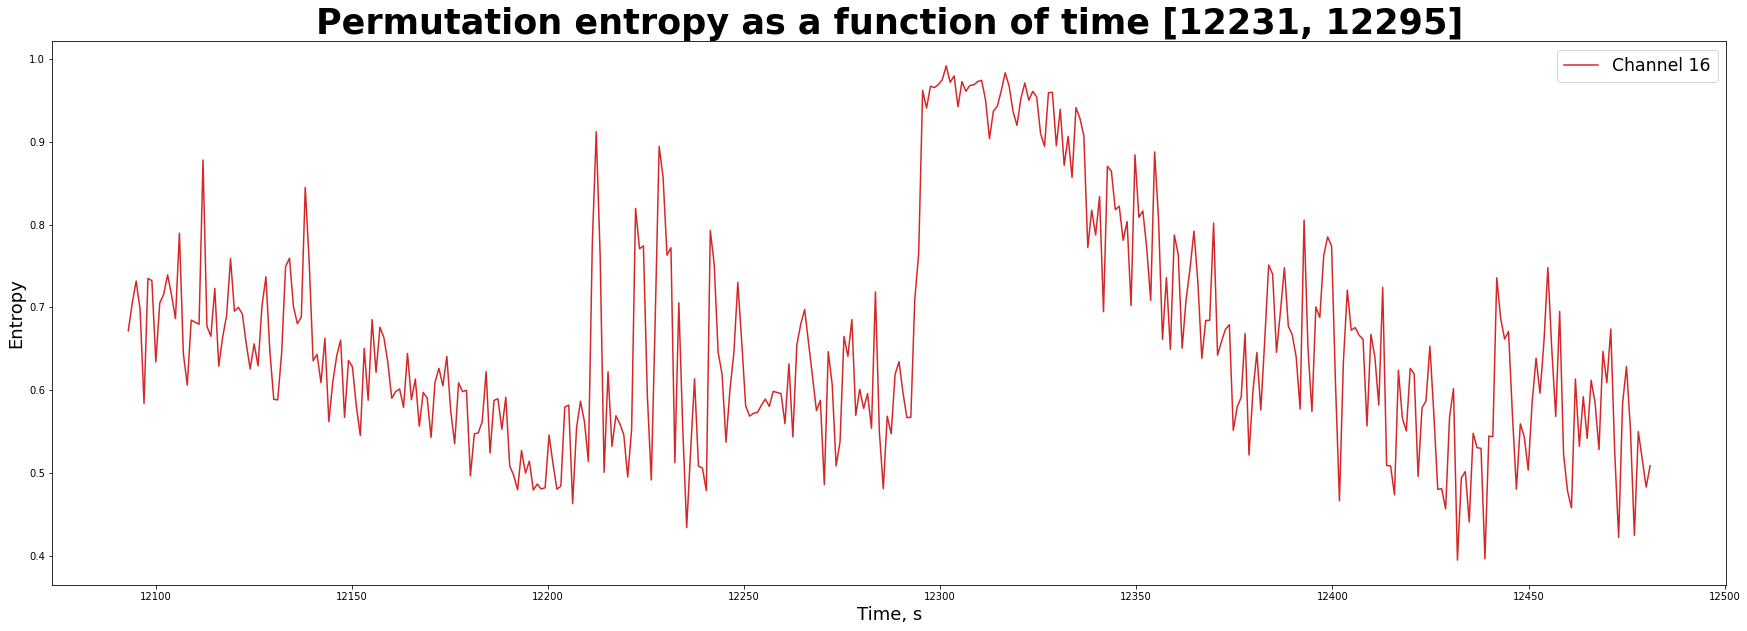

  2%|▏         | 8/388 [00:00<00:11, 32.38it/s]

Channel: 17 CZ-PZ
Number of periods: 388


100%|██████████| 388/388 [00:11<00:00, 34.35it/s]


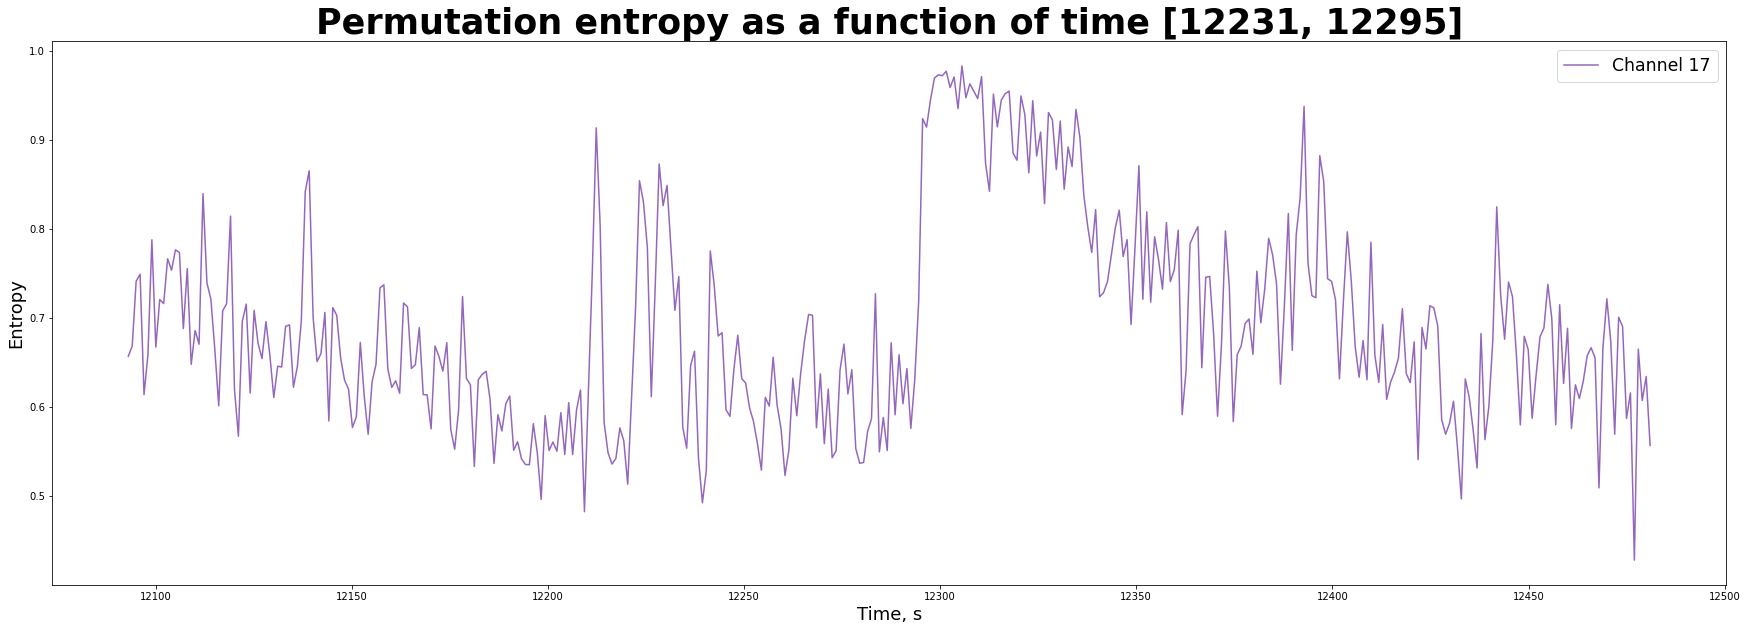

  1%|          | 4/388 [00:00<00:10, 35.64it/s]

Channel: 18 P7-T7
Number of periods: 388


100%|██████████| 388/388 [00:09<00:00, 40.44it/s]


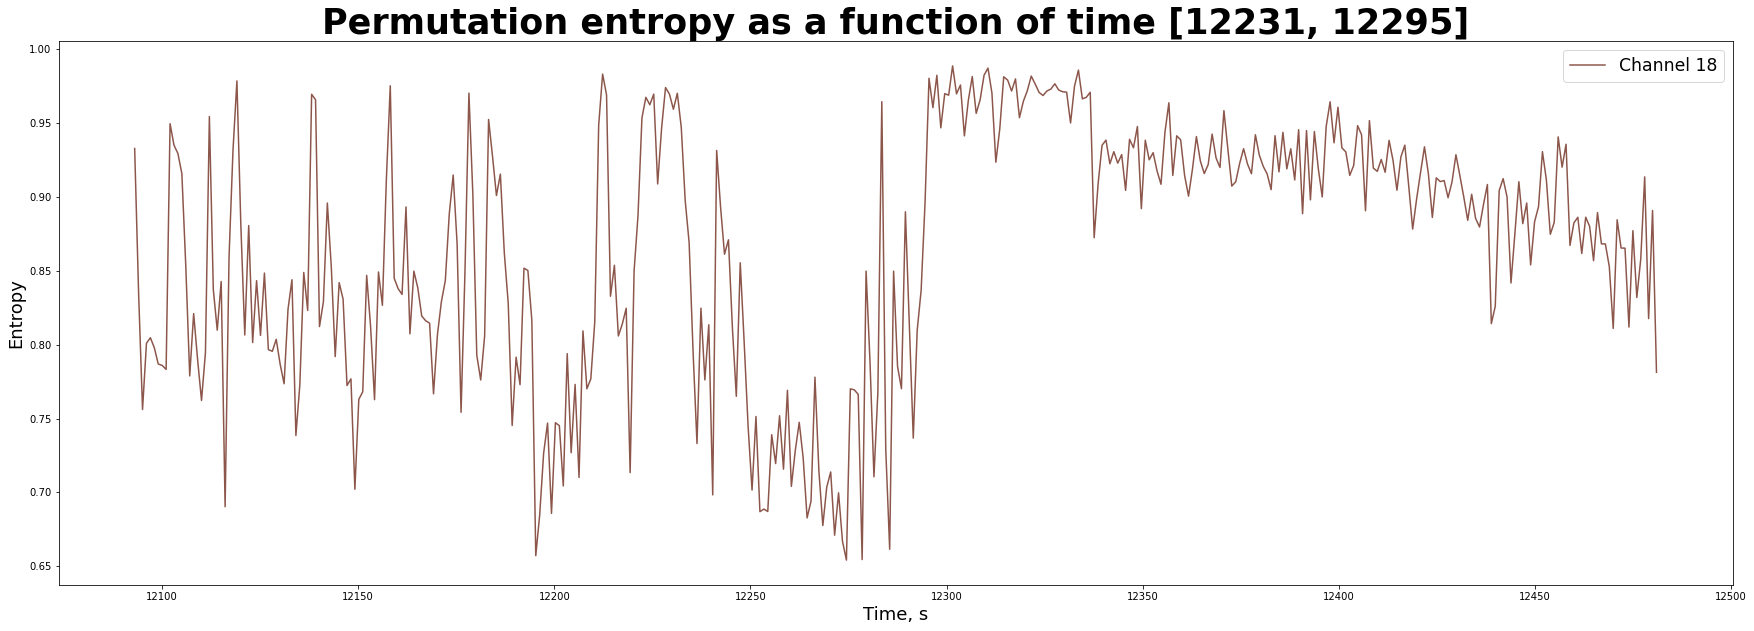

  1%|          | 4/388 [00:00<00:10, 38.08it/s]

Channel: 19 T7-FT9
Number of periods: 388


100%|██████████| 388/388 [00:09<00:00, 38.94it/s]


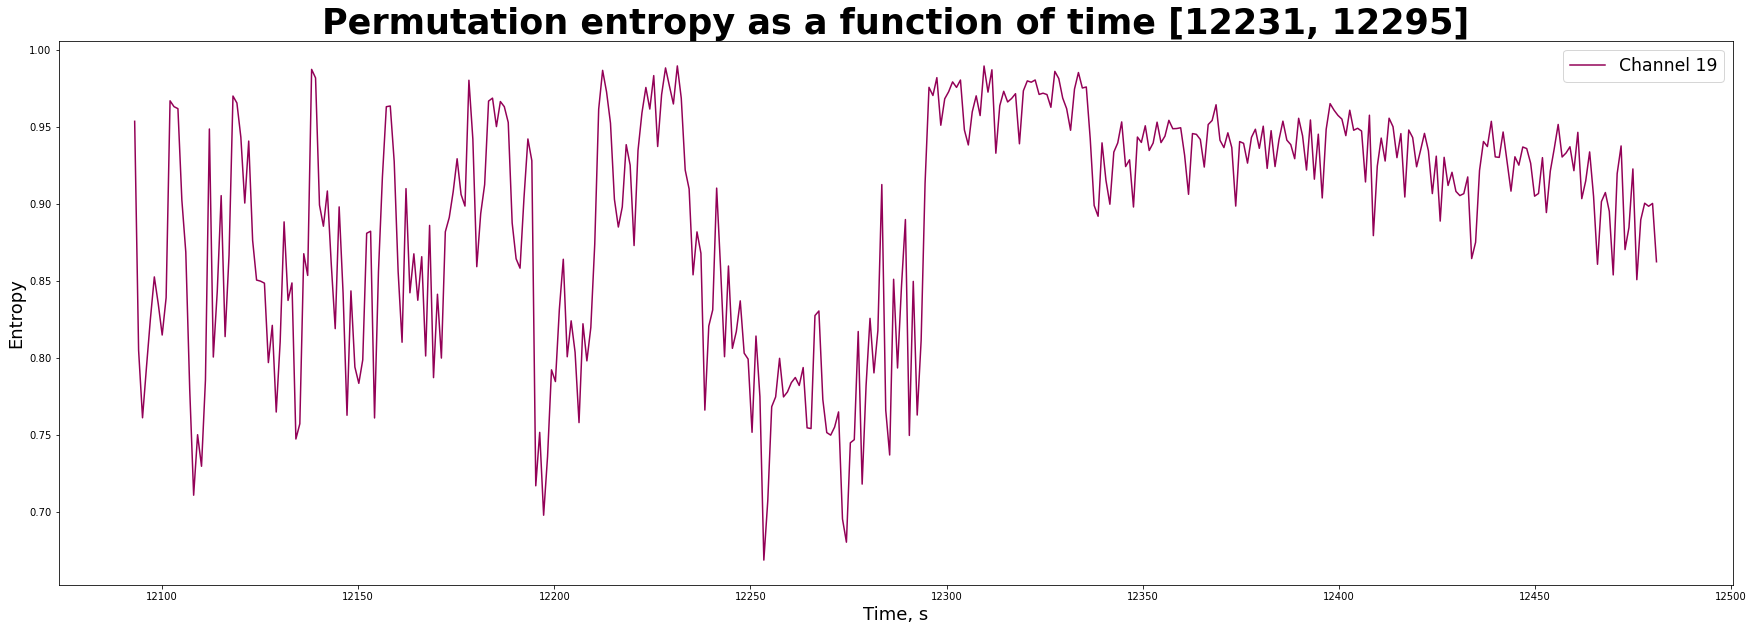

  1%|          | 4/388 [00:00<00:10, 35.66it/s]

Channel: 20 FT9-FT10
Number of periods: 388


100%|██████████| 388/388 [00:09<00:00, 39.08it/s]


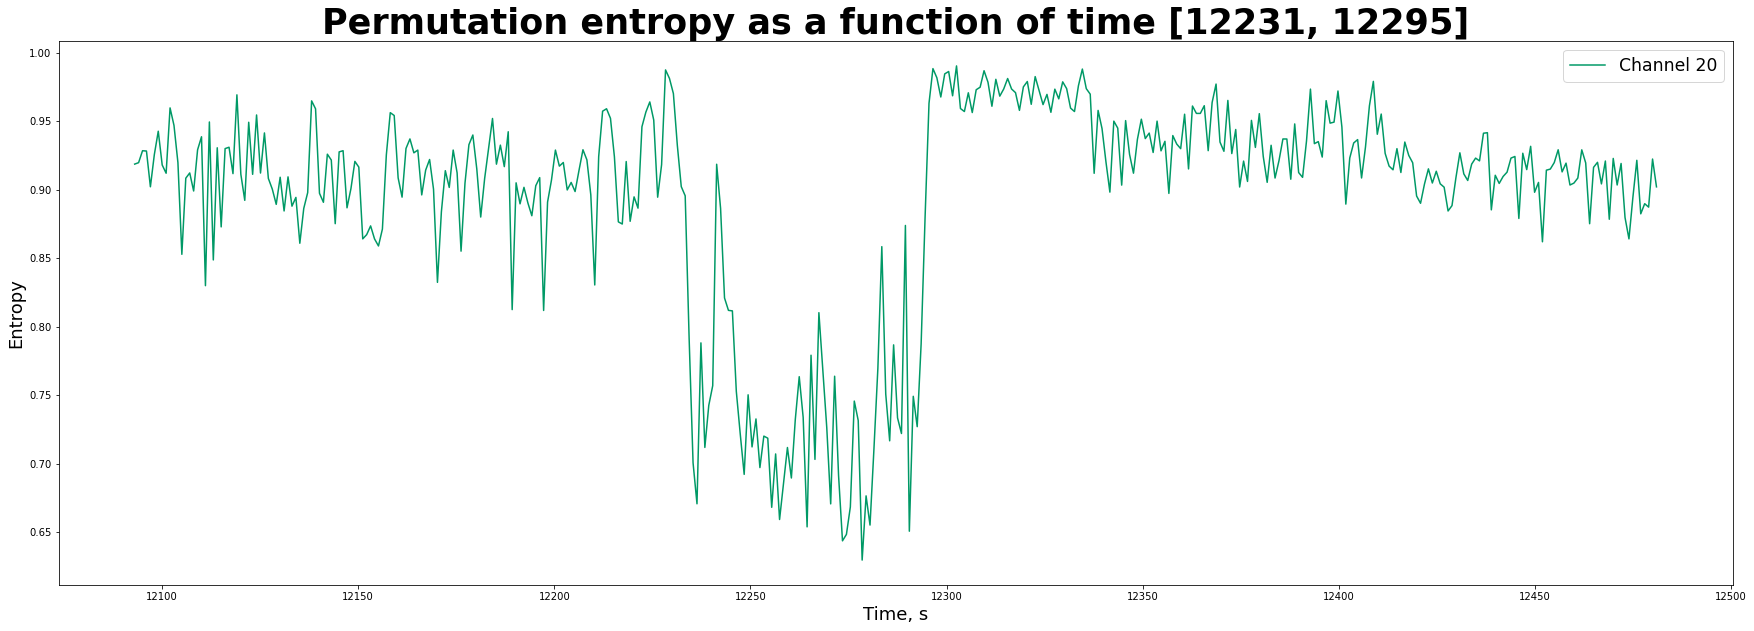

  2%|▏         | 6/388 [00:00<00:15, 24.29it/s]

Channel: 21 FT10-T8
Number of periods: 388


100%|██████████| 388/388 [00:10<00:00, 38.37it/s]


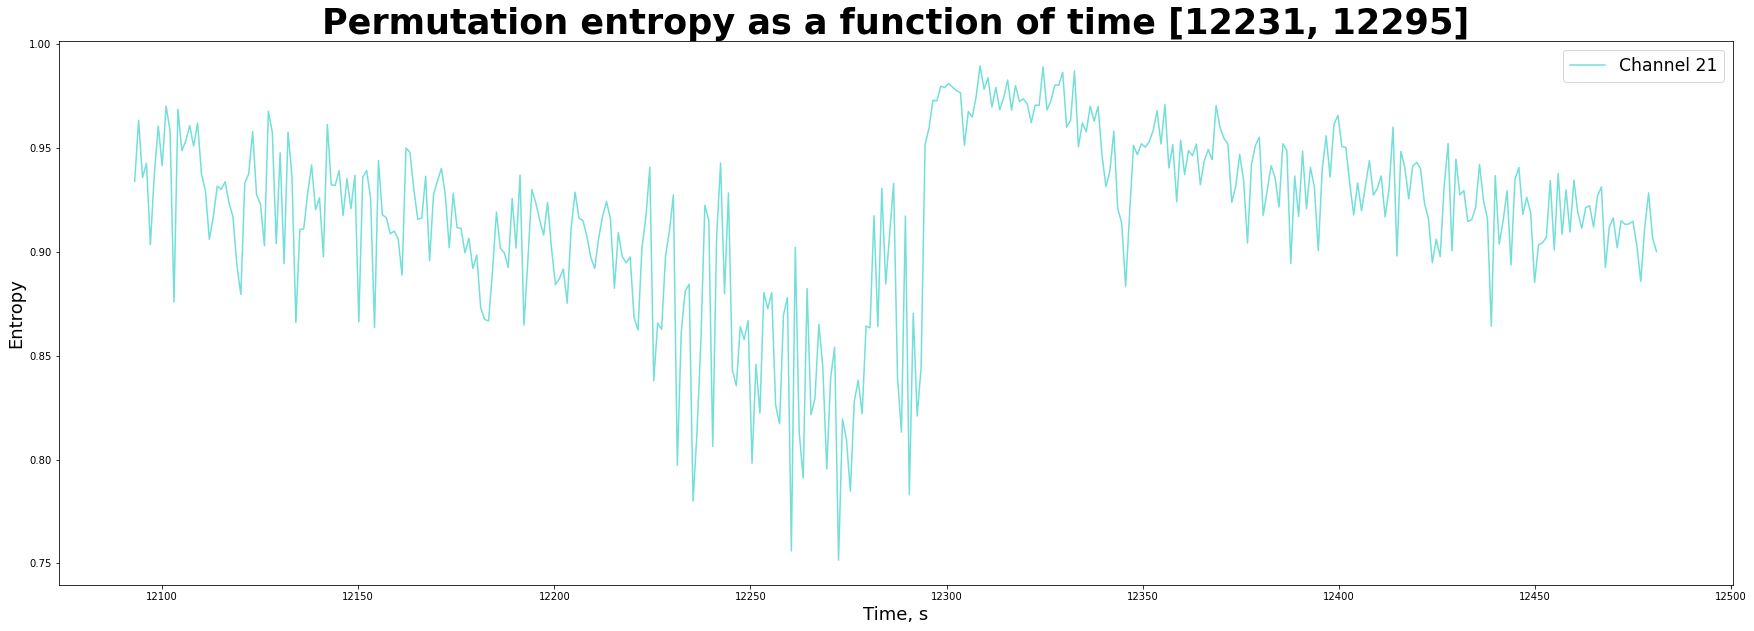

  1%|          | 4/388 [00:00<00:10, 35.08it/s]

Channel: 22 T8-P8-1
Number of periods: 388


100%|██████████| 388/388 [00:10<00:00, 36.95it/s]


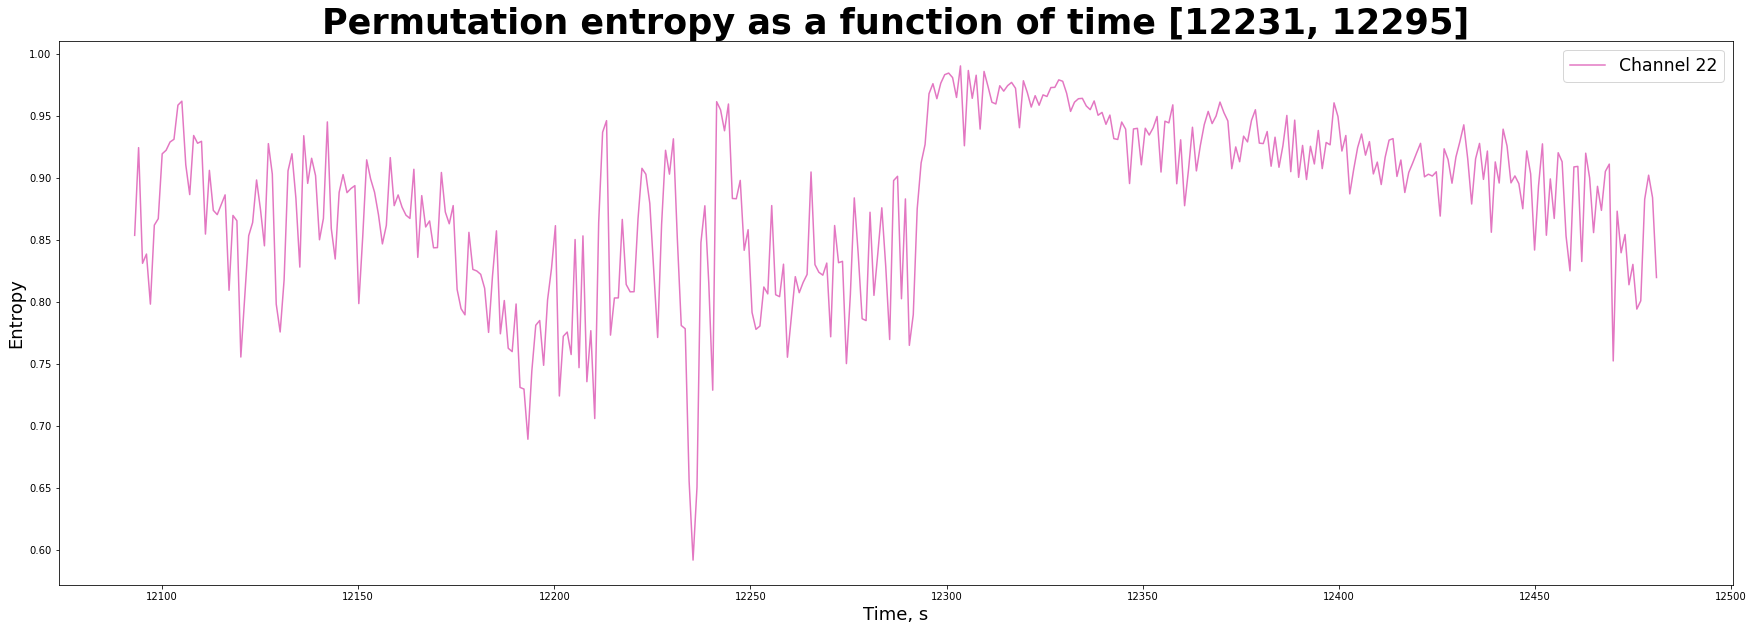

  1%|          | 4/388 [00:00<00:10, 35.66it/s]

Channel: 23 VNS
Number of periods: 388


100%|██████████| 388/388 [00:10<00:00, 37.51it/s]


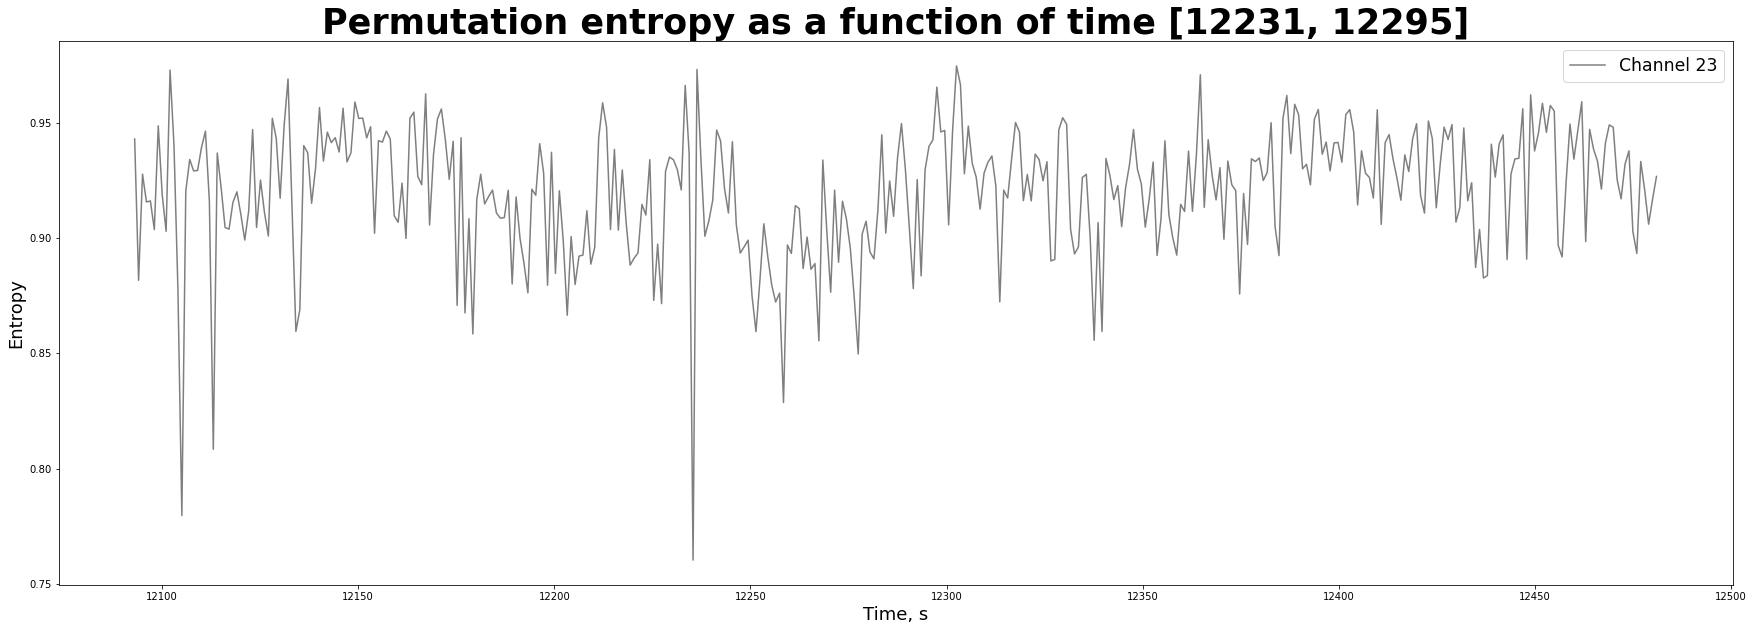

In [27]:
for sample in samples:
    sample.determine_PE()

No handles with labels found to put in legend.


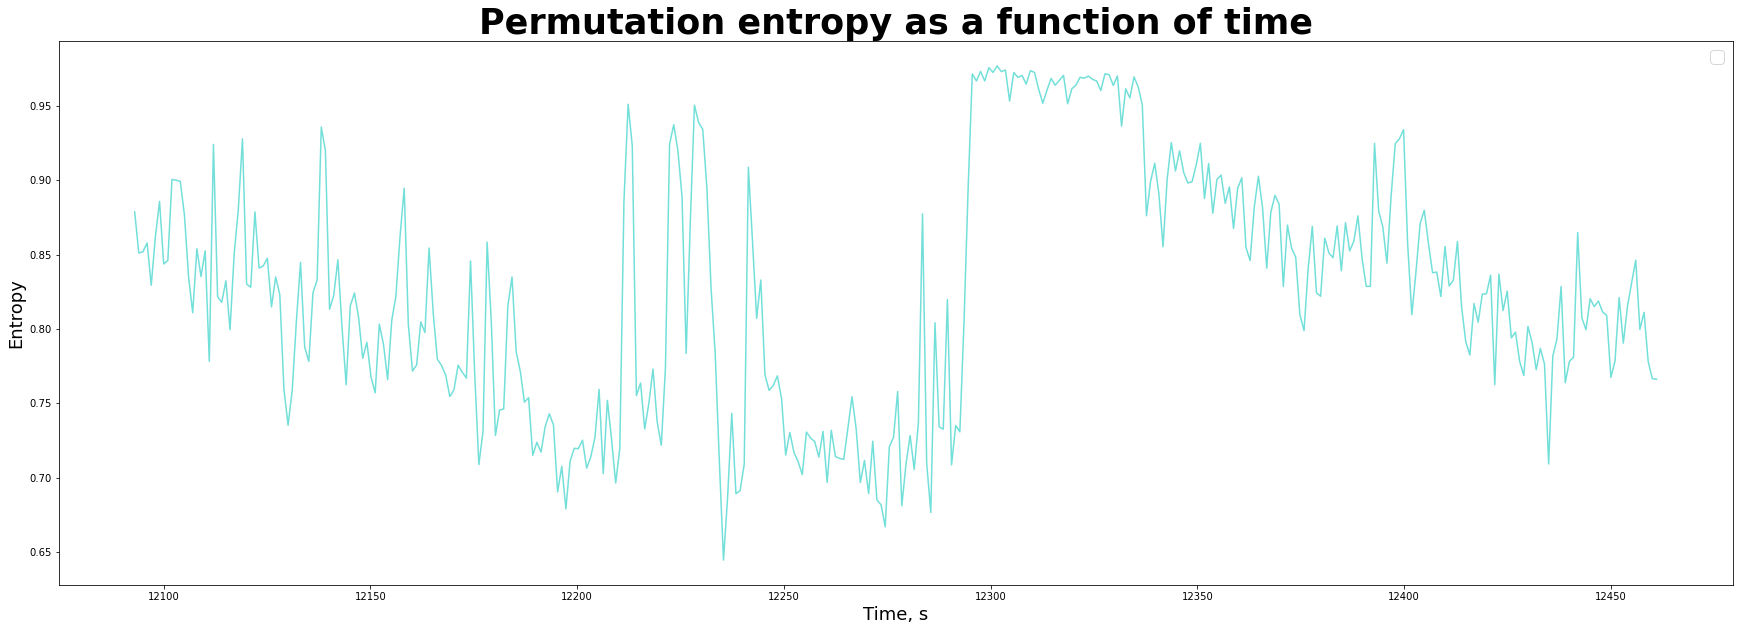

In [65]:
def plot_vector_in_time(vector, from_, to, from_time, to_time, title='Permutation entropy as a function of time',
                        xlabl='Time, s', ylabl='Entropy', labl=''):
    time_ = np.linspace(from_time, to_time, len(vector))

    fig = plt.figure(figsize=(30, 10))
    vector = vector[from_:to]
    plt.plot(time_, vector, COLORS[8], label=labl)
    plt.xlabel(xlabl, fontsize=18)
    plt.ylabel(ylabl, fontsize=18)
    plt.title(title, weight='bold', fontsize=35)
    plt.legend(fontsize='xx-large')
    return plt.show()

for sample in samples:
    plot_vector_in_time(sample.average_pe, 0, len(sample.average_pe), sample.seizure_time[0]-sample.window_before,
                       sample.seizure_time[1]+sample.window_after)

Fitting ICA


/Users/sofiyagarkot/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


fitting took: 379.5352818965912
ICA shape (3686144, 24)
Plotting


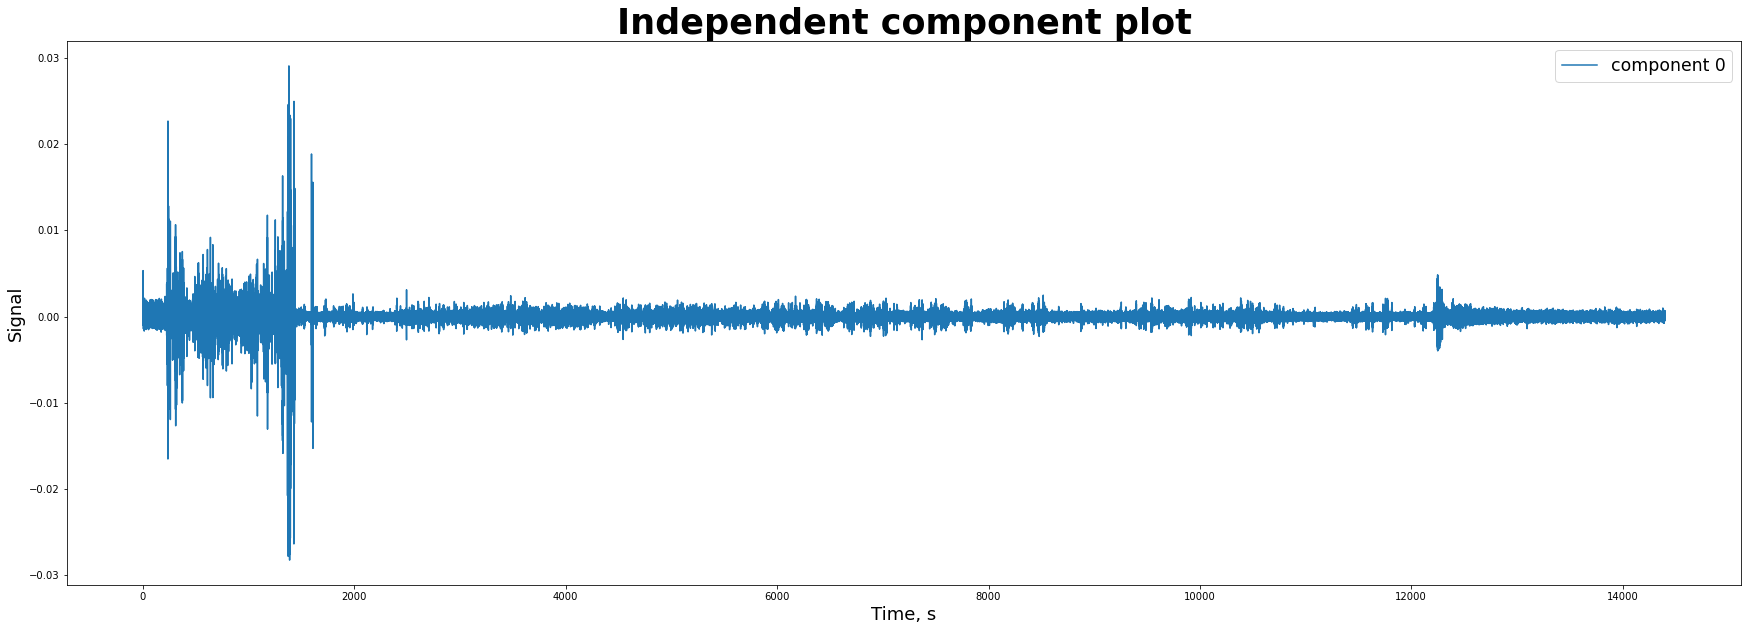

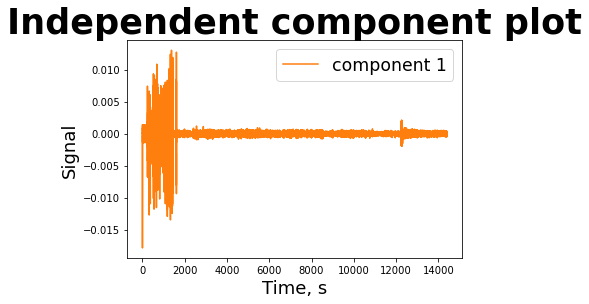

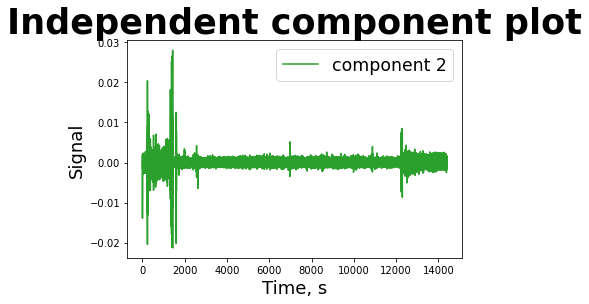

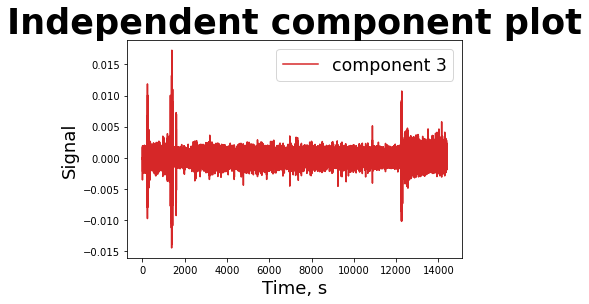

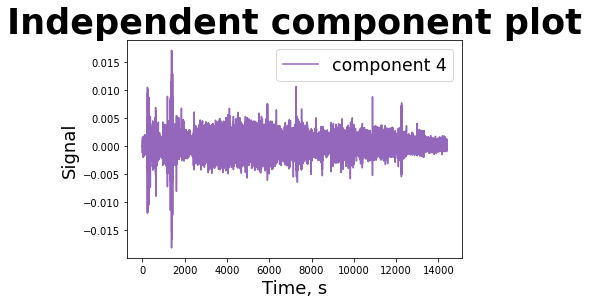

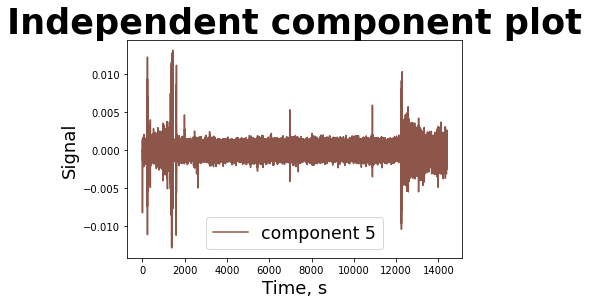

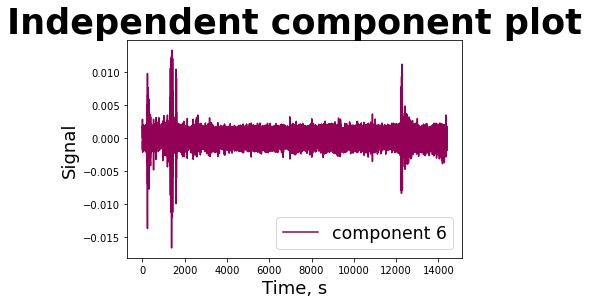

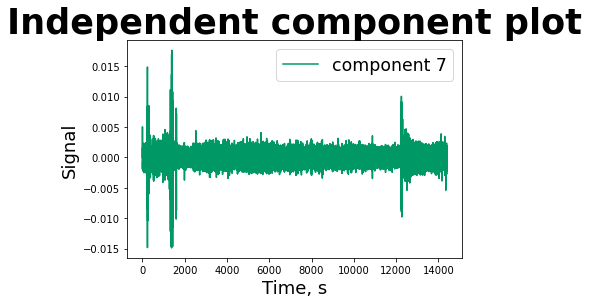

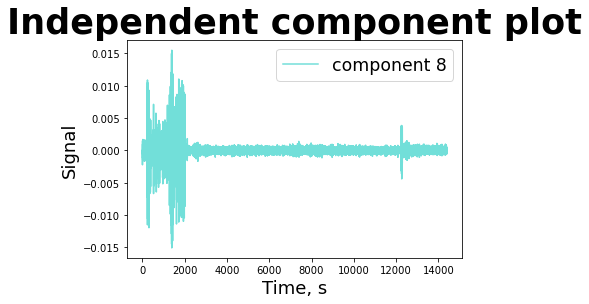

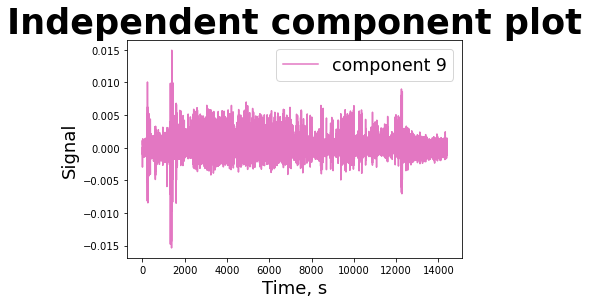

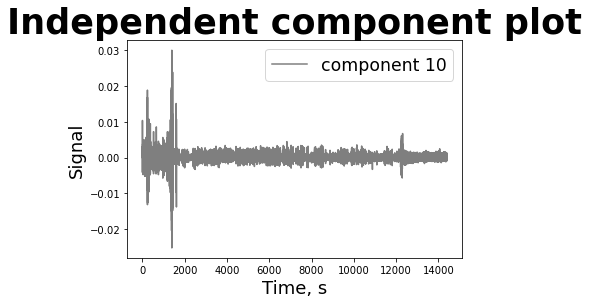

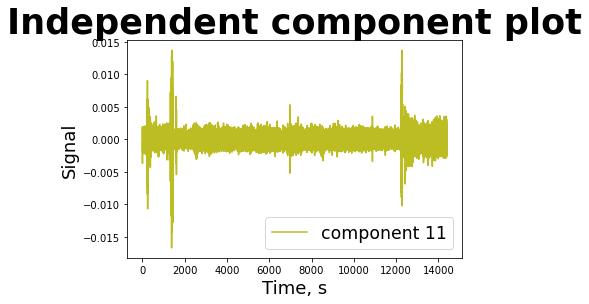

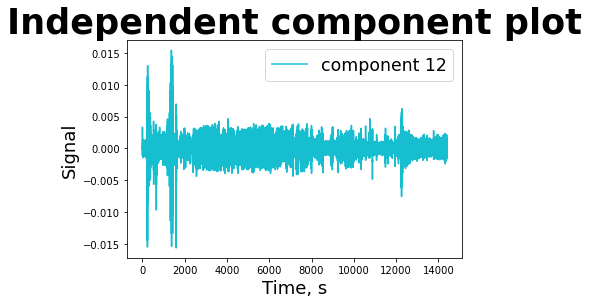

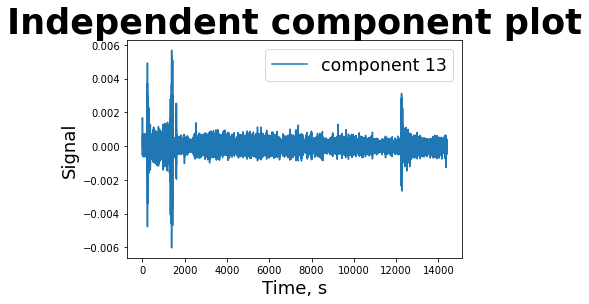

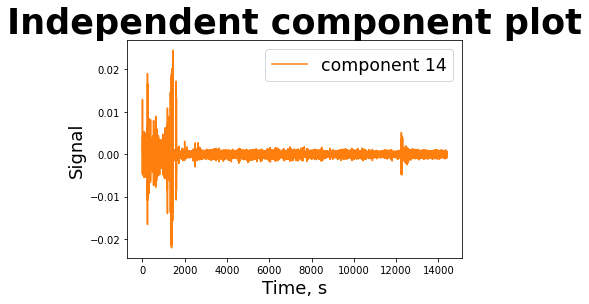

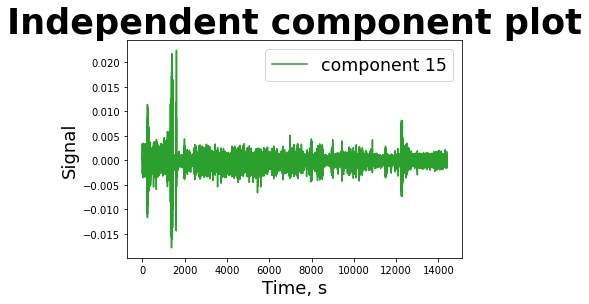

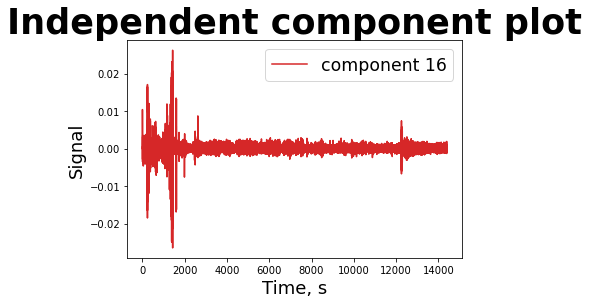

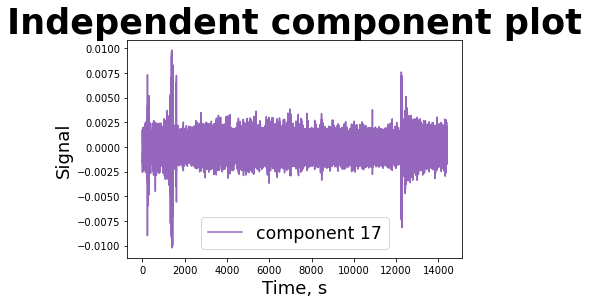

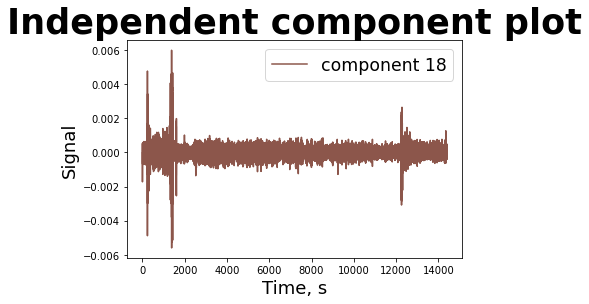

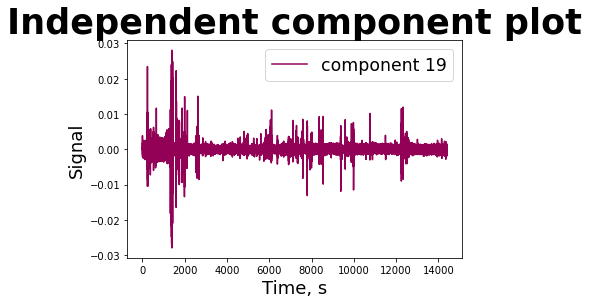

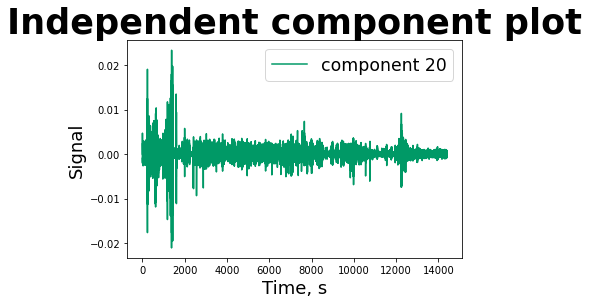

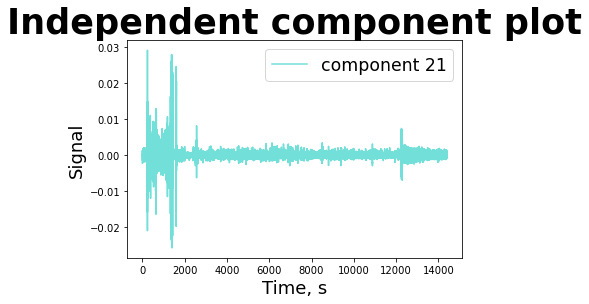

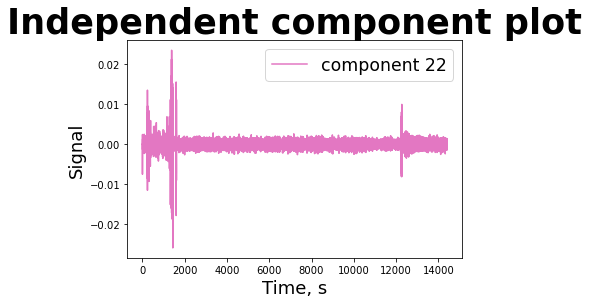

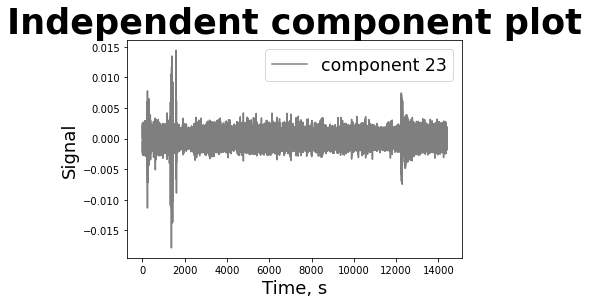

No handles with labels found to put in legend.


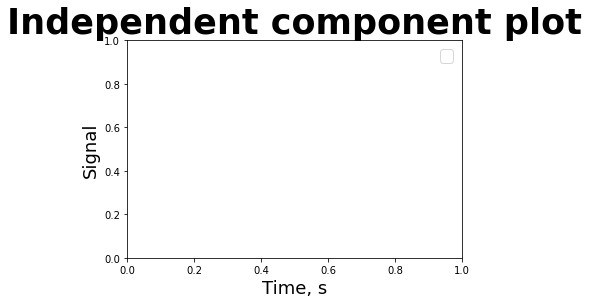

In [34]:
for sample in samples:
    sample.determine_ica()
#     sample.determine_pe_ica()

In [ ]:
# plot_vector_in_counts(sample.ica[0], from_=0, to=sample.ica.shape[0] // 256, title='Independent component plot',
#                               xlabl='Time, s', ylabl='Signal', labl='component 0')



Used previously to visualize how the method works.

In [52]:
# from sklearn.linear_model import LinearRegression

# slopes={}
# def staring_seizure_extraction_using_sample(sample, len_window, len_step, k_boundary):
#     '''
#     sample --> EEG_sample
#     len_window, len_step --> int
#     k_boundary --> float
#     '''
# #     len_window = len_window*256
# #     len_step = len_step*256
# #     pe_ = sample.ica[1][(sample.seizure_time[0] - sample.window_before)*256:(sample.seizure_time[1]+sample.window_after)*256]
#     pe_ = pe_ica[10]
#     slopes[(len_window, len_step)] = []
    
#     end_seizure = str(len(pe_)-sample.window_after)
#     fig = plt.figure(figsize=(40, 10))
#     time_ = np.arange(0, len(pe_), 1)
#     plt.plot(time_, pe_, 'o')
# #     plt.show()
    
#     for i in tqdm(range(0, len(pe_)-len_window, len_step)):
#         x = np.array([j for j in range(len_window)])
#         y = np.array([pe_[j] for j in range(i, i+len_window)])
        
#         m, b = np.polyfit(x, y, 1)
#         time_2 = [j for j in range(i, i+len_window)]
#         plt.plot(time_2, m*x + b)
#         slopes[(len_window, len_step)].append(m)
        
#     plt.axvline(x=sample.window_before)
#     plt.axvline(x=len(pe_)-sample.window_after)
#     plt.xlabel('Time, s', fontsize=18)
#     plt.ylabel('Entropy', fontsize=18)
#     plt.title("PE ICA (component 10)" , weight='bold', fontsize=35)
#     plt.show()

In [53]:
# len(pe_ica[0])

In [54]:
# staring_seizure_extraction_using_sample(sample, 20, 5, 0.008)

Predicting

In [35]:
pe_predictor = PermutationEntropyPredictor()

In [36]:
pe_predictor.fit(samples, optimize = True)

  0%|          | 0/950 [00:00<?, ?trial/s, best loss=?]

job exception: 'EEG_sample' object has no attribute 'average_pe'



  0%|          | 0/950 [00:00<?, ?trial/s, best loss=?]


AttributeError: 'EEG_sample' object has no attribute 'average_pe'

In [ ]:
pe_predictor.best

In [ ]:
pe_predictor.predict(sample, True), sample.seizure_times

In [108]:
# !pip install statsmodels
from statsmodels.tsa.stattools import adfuller
def get_ica(s):
#     raw_data = s.filtered_signal.T
    np.random.seed(0)

    ica = FastICA(n_components=24)
    print("Fitting ICA")
    start = time.time()
#     S_ = ica.fit_transform(raw_data)
    print("fitting took:", time.time() - start)

    S_ = s.ica
    print('ICA shape', S_.shape)
    print('Plotting')
    plot_matrix_in_counts(S_, from_=0, to=S_.shape[1] // 256, title='Independent component plot',
                          xlabl='Time, s', ylabl='Signal', labl=['component ' + str(i) for i in range(S_.shape[0])],
                          separate=True)

    # SELECTING only stationary time series
    result = []
    for i, component in enumerate(S_):
        result = adfuller(component)
        print("For component "+str(i)+" result is "+str(result))
        print("P-value:", str(result[1]))
        if result[1] > 0.05:
            result.append(component)

    result = np.ndarray(result)
    return result



Fitting ICA
fitting took: 9.5367431640625e-07
ICA shape (12, 3686144)
Plotting


<Figure size 2160x720 with 0 Axes>

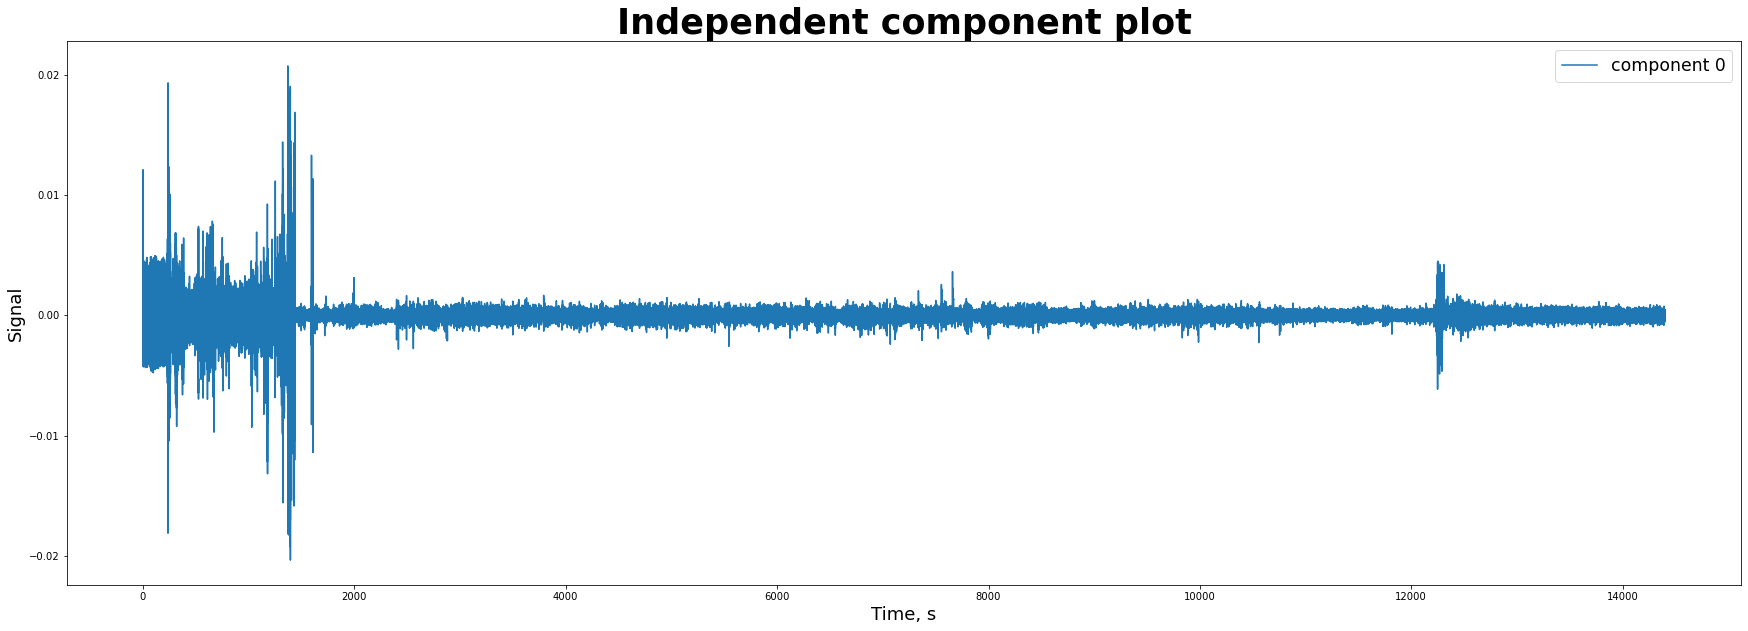

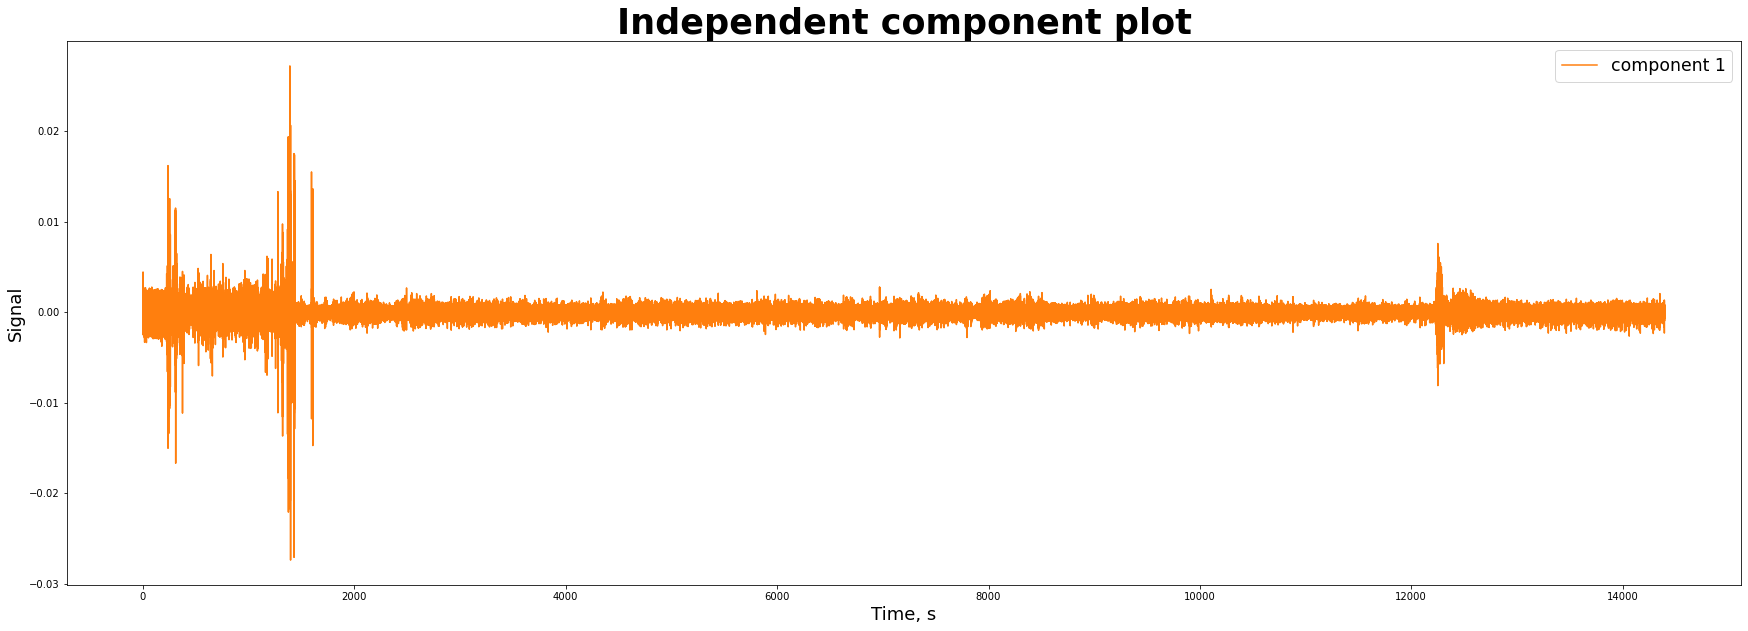

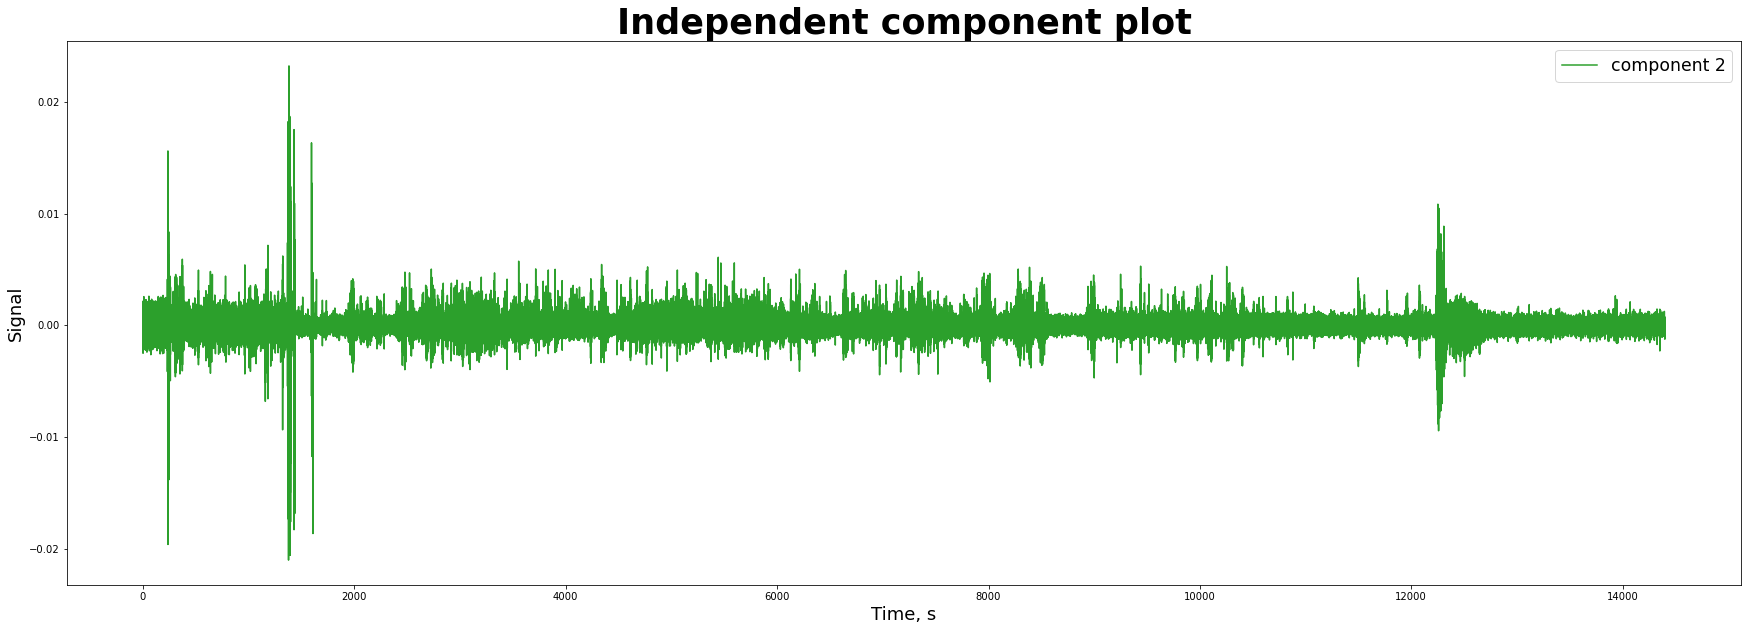

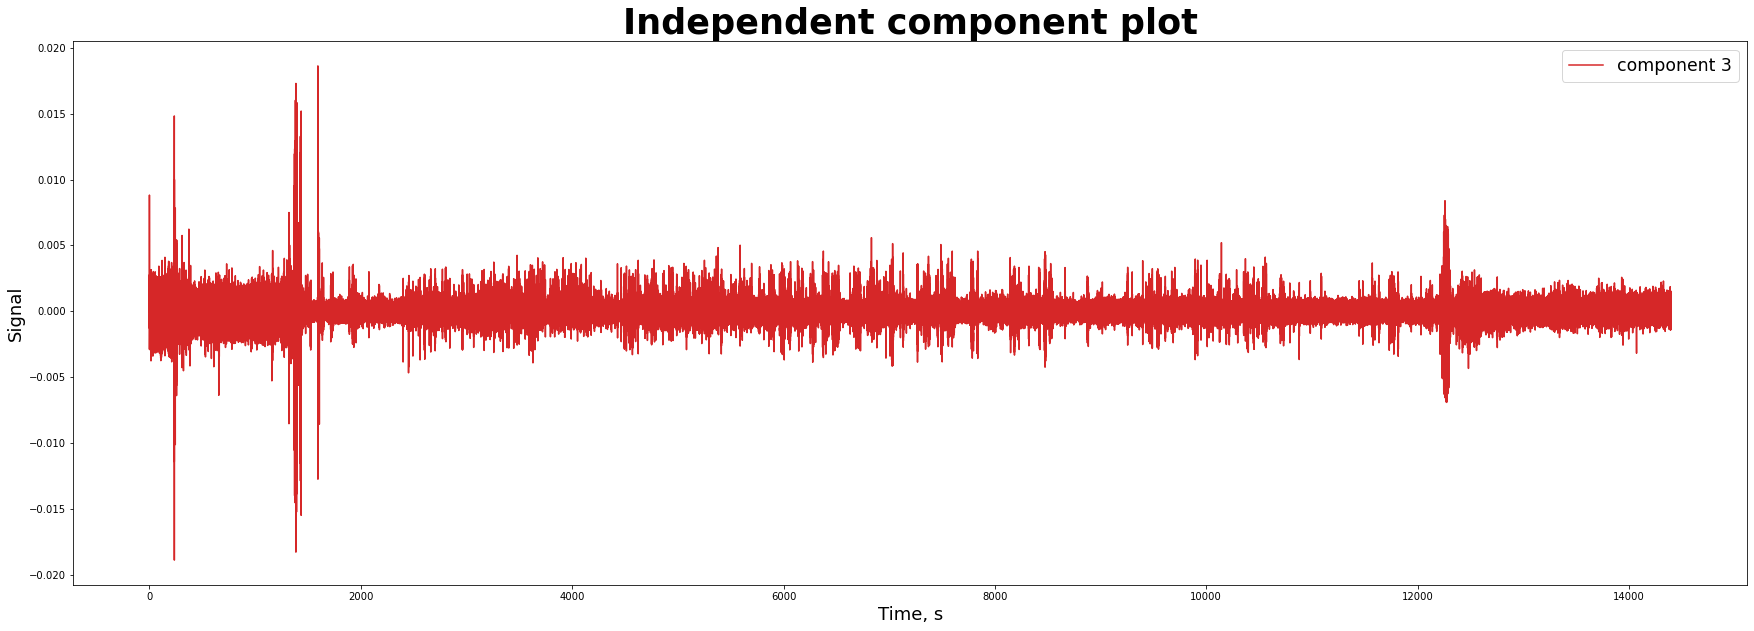

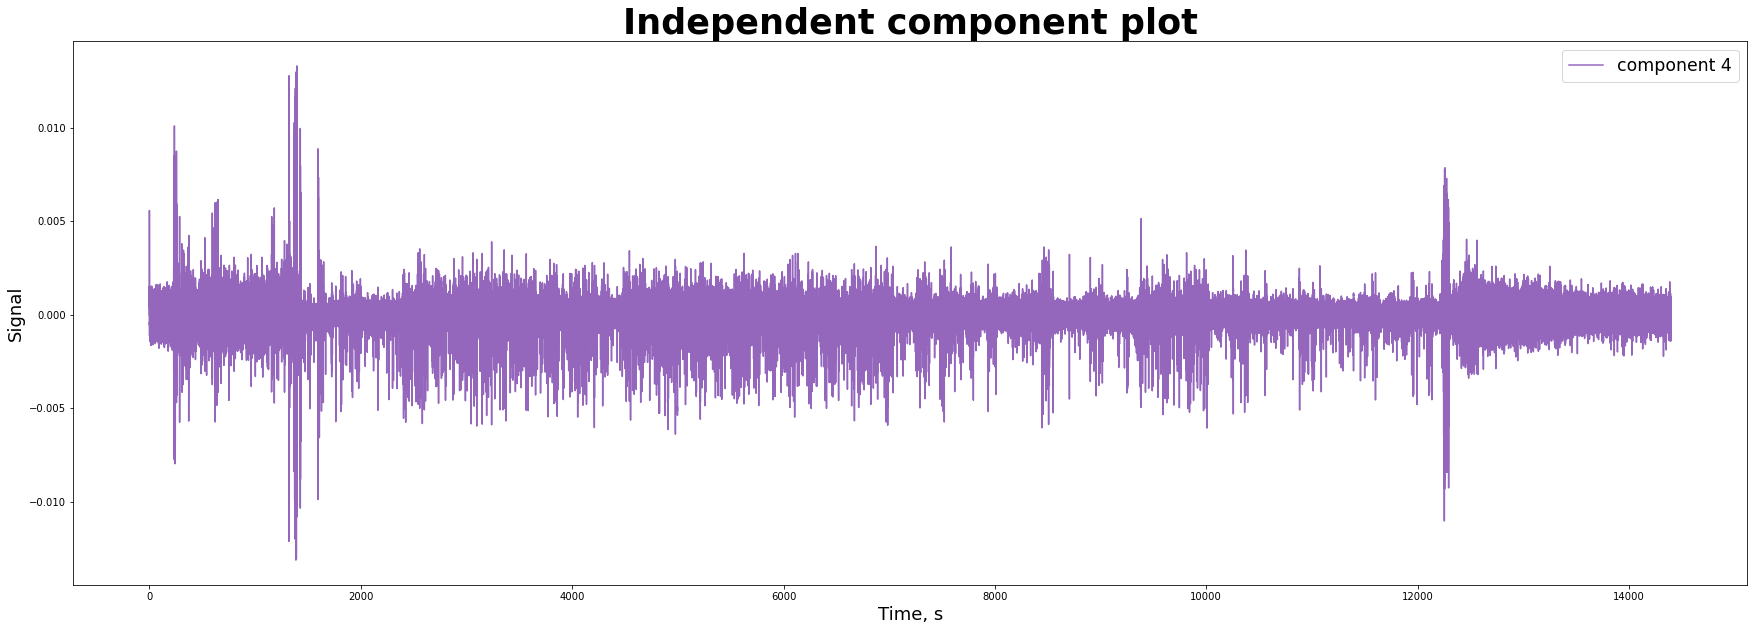

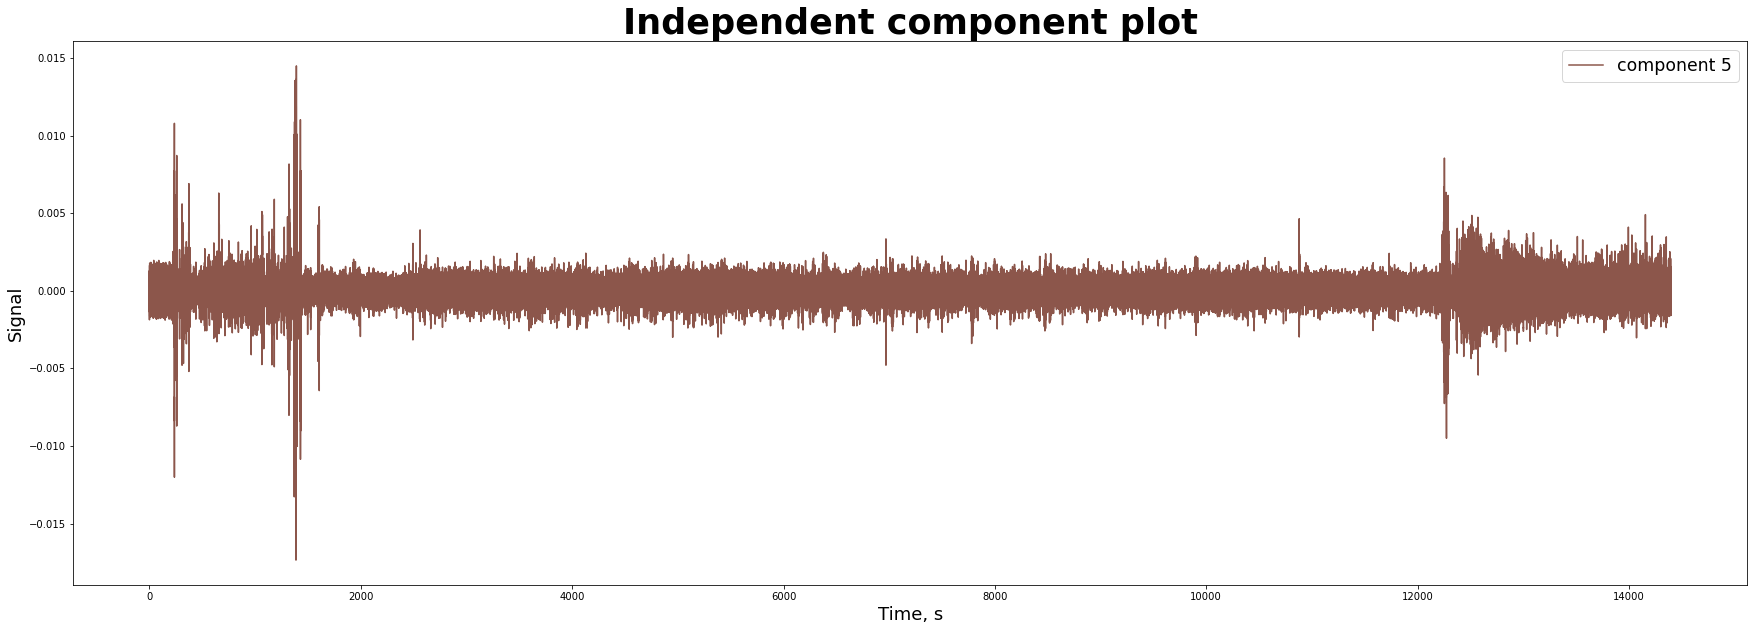

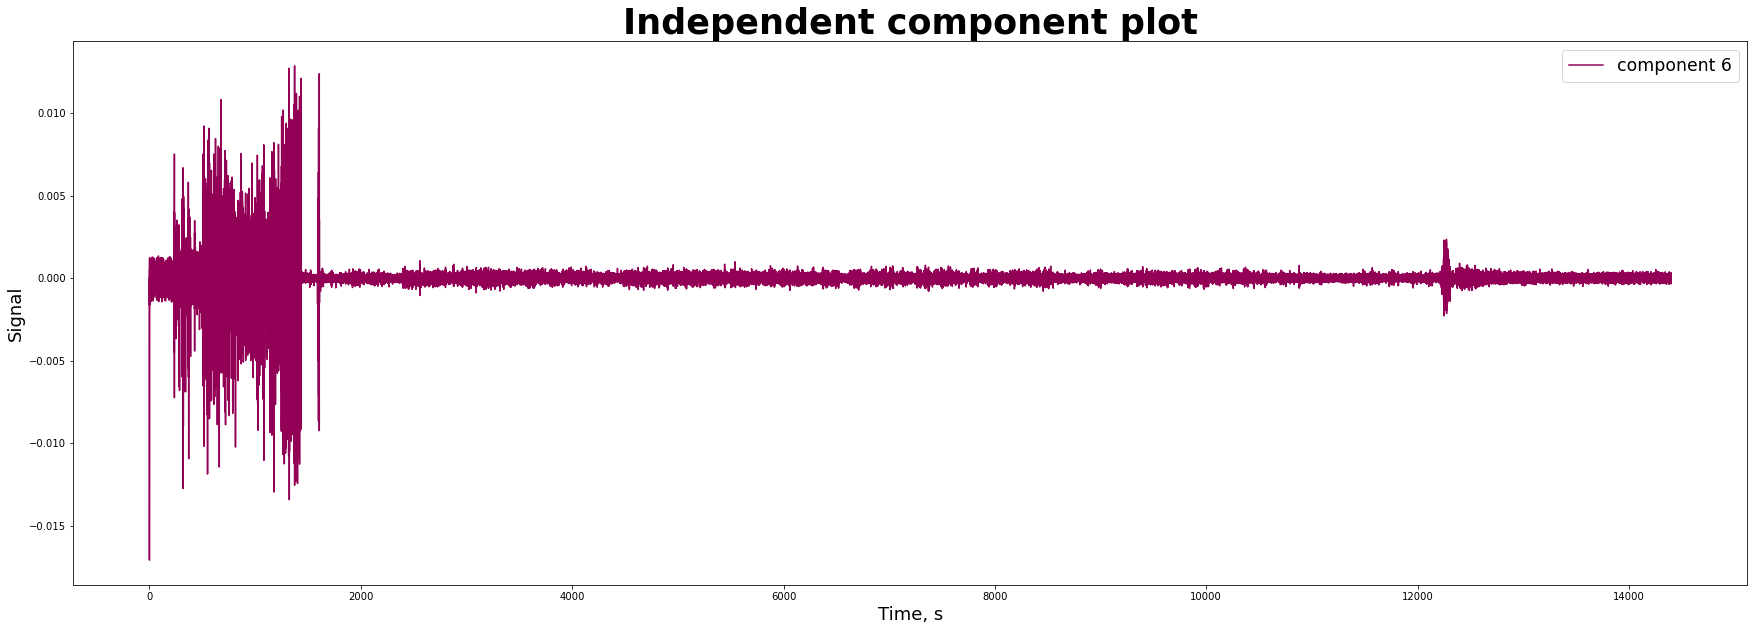

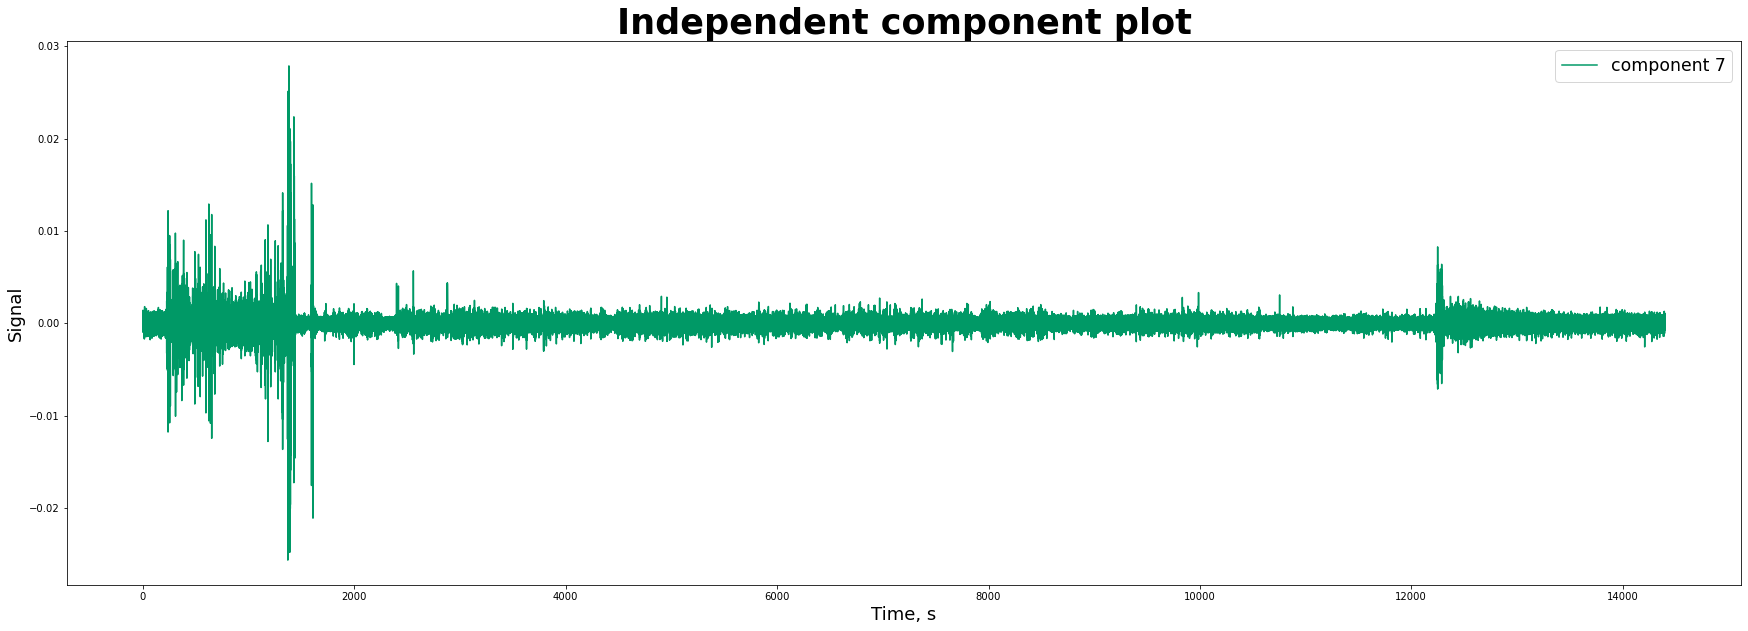

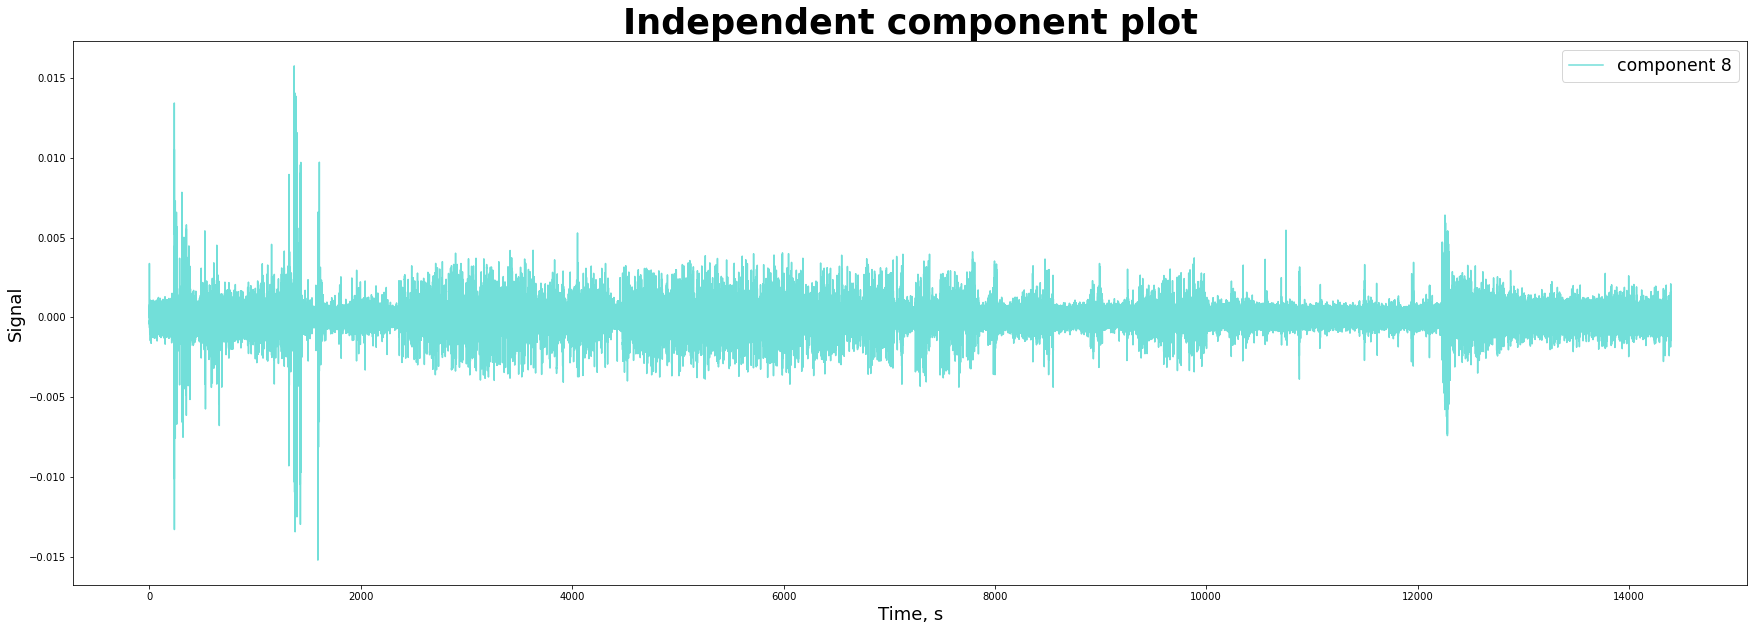

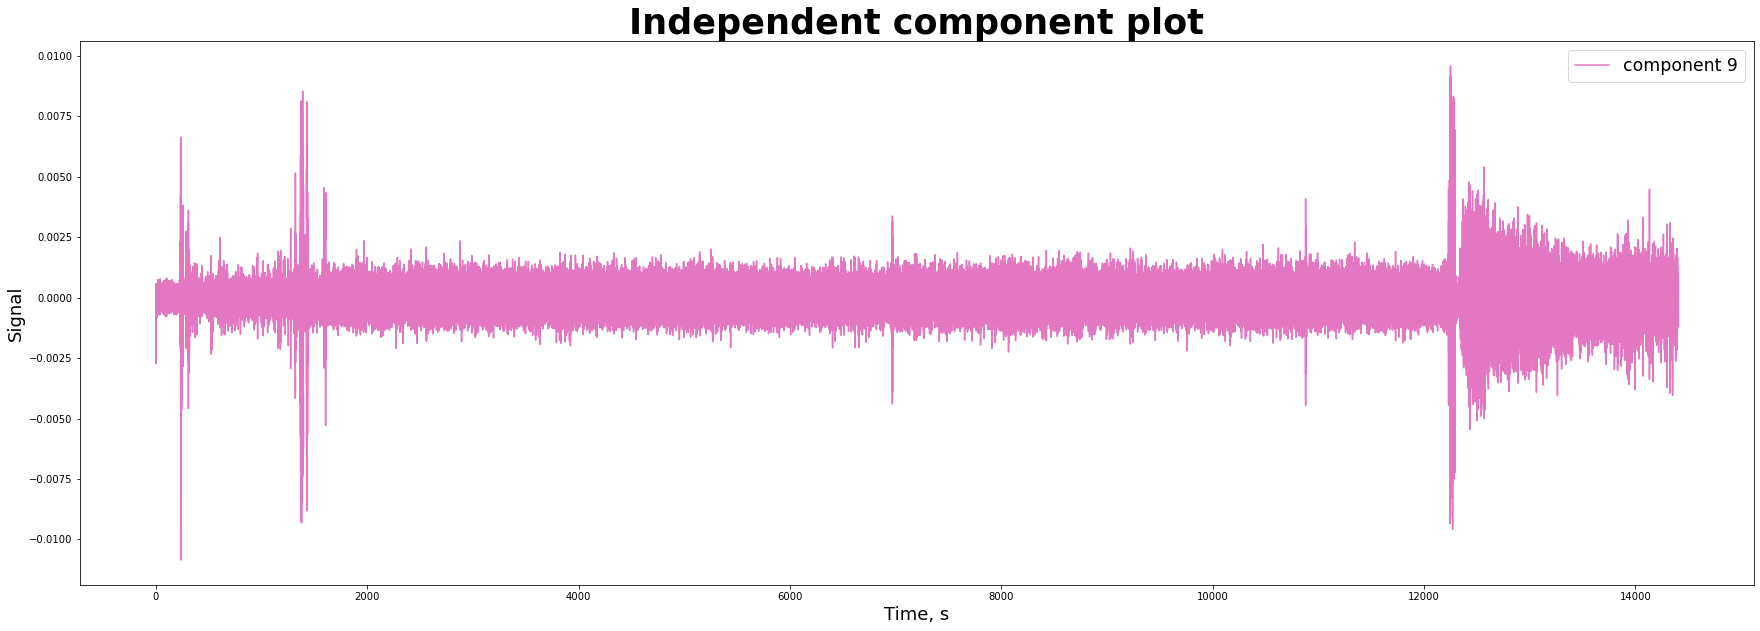

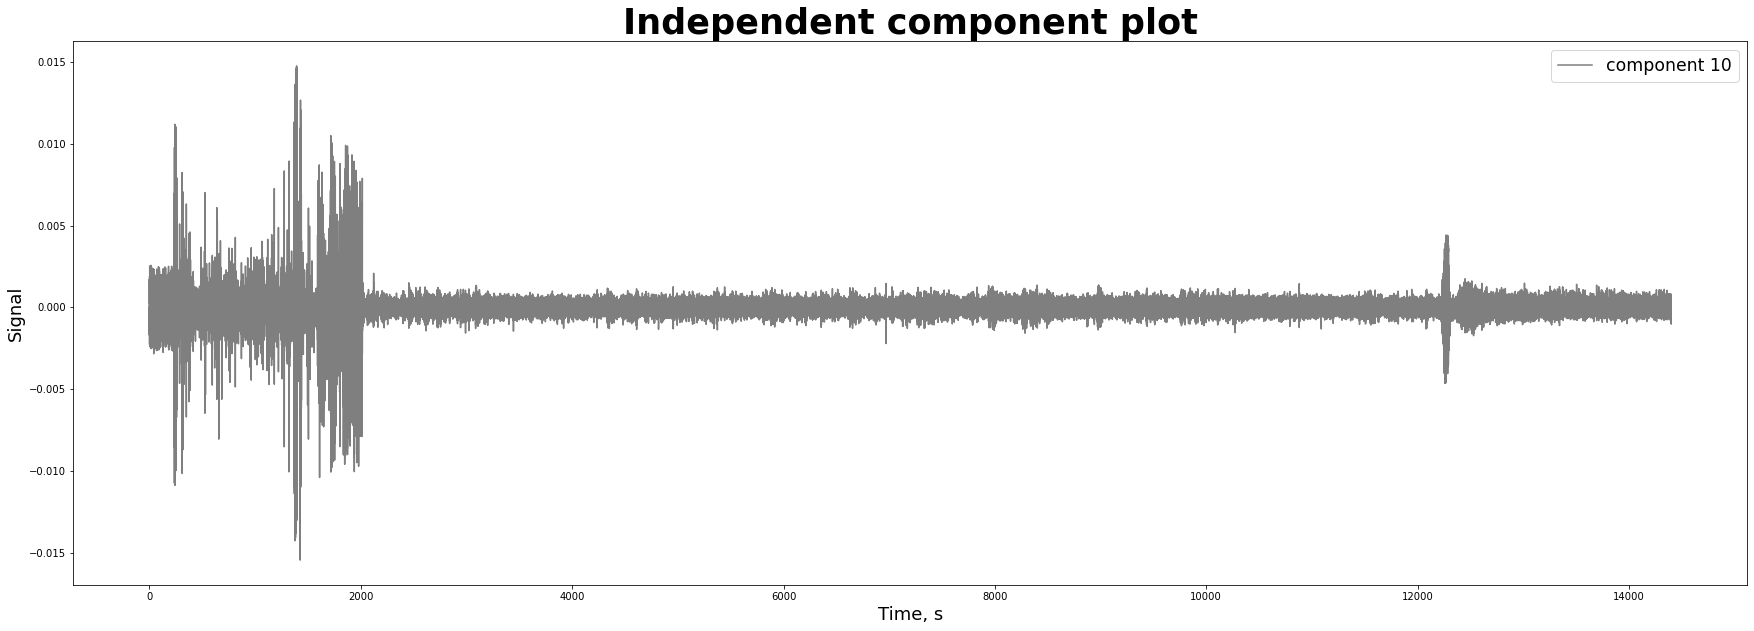

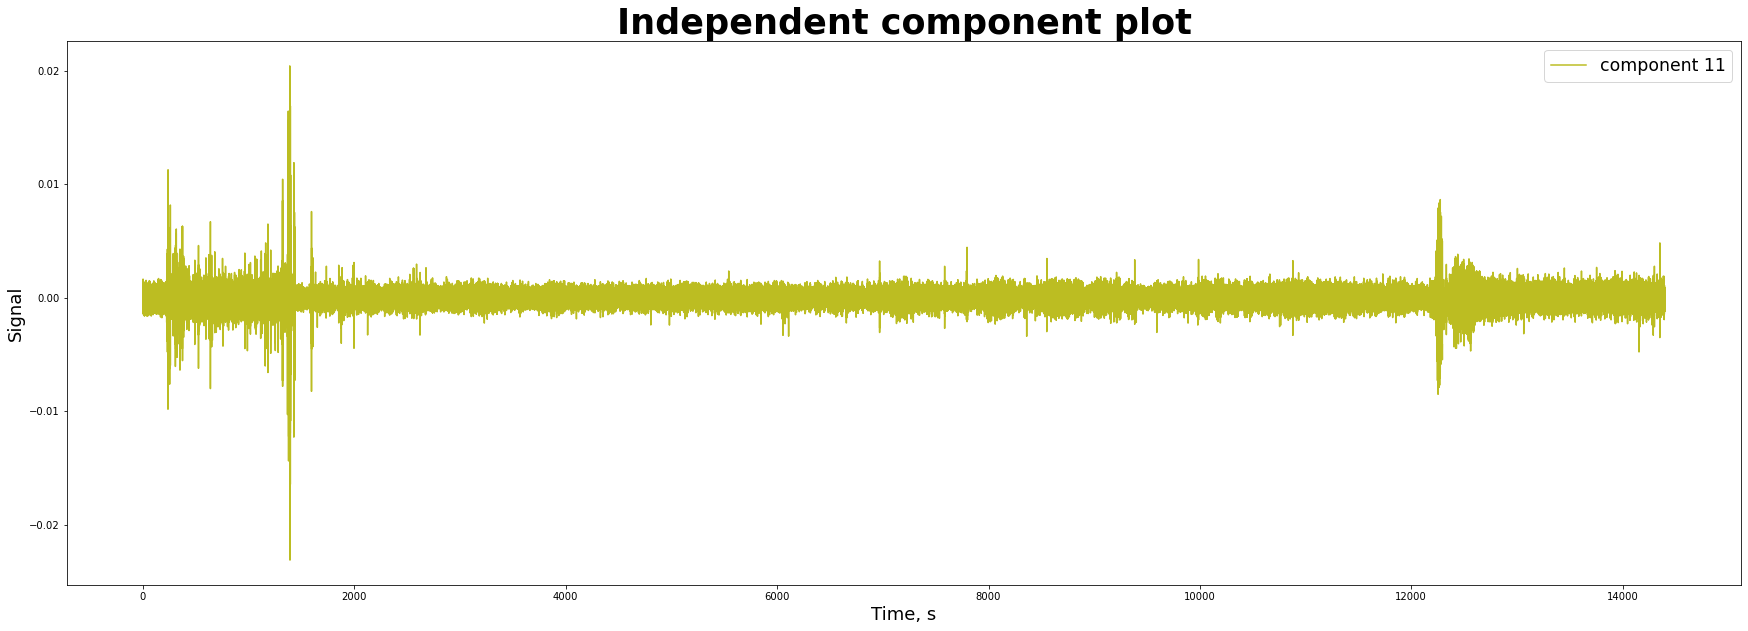

No handles with labels found to put in legend.


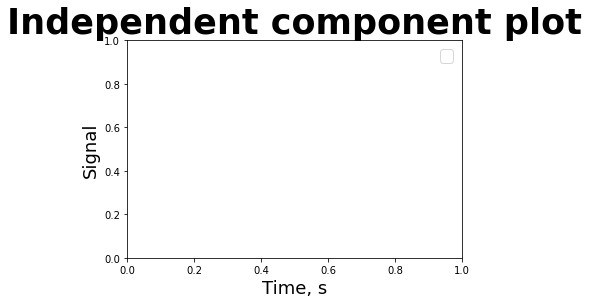

KeyboardInterrupt: 

In [ ]:
get_ica(sample)

In [38]:
len(sample.ica[0])

3686144

In [37]:
from statsmodels.tsa.stattools import adfuller
omponent = sample.ica[0]
result = adfuller(omponent)
print("For component "+str(1)+" result is "+str(result))
print("P-value:", str(result[1]))
# if result[1] > 0.05:
#     result.append(component)

KeyboardInterrupt: 